# Project Introduction

In this project, I aim to create a model that predicts sales and suggests products for my cafe. To achieve this, I have collected various datasets, including:

- **Item Sales and Daily Sales**: Data from my cafe, available in CSV format.
- **Weather Data for Montreal**: Collected from APIs.
- **Macroeconomic Indicators**: Collected from APIs.
- **Local Holidays for Quebec**: Collected from APIs.
- **Pedestrianization Data**: Manual input (after concatenating all datasets)

The goal is to utilize these datasets to build a predictive model. At this stage, I have completed the initial data collection.

#### Imports

In [1]:
import importlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from scripts import data_fetching as df
from scripts import data_preprocessing as dp
from scripts import feature_engineering as fe
from scripts import model_training as mt
from scripts import visuals as vs

importlib.reload(df)
importlib.reload(dp)
importlib.reload(fe)
importlib.reload(mt)
importlib.reload(vs)

<module 'scripts.visuals' from '/Users/vasilisvc6/Documents/Le grand cormoran project/scripts/visuals.py'>

In [3]:
pd.set_option('display.max_rows', 20)

## Data Collection

### Initial Fetching - Preprocessing

#### Date range

In [2]:
start_date = '2023-10-01'
end_date = '2024-11-30'

#### Local holidays in QC

In [6]:
holidays = df.local_holidays_fetch(start_date=start_date, end_date=end_date)

In [7]:
holidays.to_csv('data/holidays.csv')

In [8]:
holidays['Name'].unique()

array(['Feast of St Francis of Assisi', 'Hoshana Rabbah',
       'Shemini Atzeret', 'Simchat Torah', 'Thanksgiving Day',
       'Halloween', "All Saints' Day", "All Souls' Day",
       'Daylight Saving Time ends', 'National Aboriginal Veterans Day',
       'Remembrance Day', 'Diwali/Deepavali', 'First Sunday of Advent',
       'Feast of the Immaculate Conception', 'First Day of Hanukkah',
       'Anniversary of the Statute of Westminster',
       'Last day of Hanukkah', 'December Solstice', 'Christmas Eve',
       'Christmas Day', 'Kwanzaa (first day)', "New Year's Eve",
       "New Year's Day", 'Day After New Year’s Day', 'Epiphany',
       'Orthodox Christmas Day', 'Orthodox New Year',
       "Tu B'Shevat (Arbor Day)", 'Groundhog Day', "Isra and Mi'raj",
       'Lunar New Year', 'Carnival / Shrove Tuesday / Pancake Day',
       'Ash Wednesday', "Valentine's Day", 'National Flag of Canada Day',
       "St David's Day", 'Daylight Saving Time starts', 'Ramadan Start',
       'Commonweal

Let's create a csv file for the holidays so we don't spend all of our available API requests.

In [6]:
holidays = pd.read_csv('data/holidays.csv')

In [7]:
holidays.set_index('Date', inplace=True)

In [8]:
holidays

Name
Date                                                 
2023-10-04              Feast of St Francis of Assisi
2023-10-06                             Hoshana Rabbah
2023-10-07                            Shemini Atzeret
2023-10-08                              Simchat Torah
2023-10-09                           Thanksgiving Day
...                                               ...
2024-08-15                         Assumption of Mary
2024-09-02                                 Labour Day
2024-09-16                     Milad un Nabi (Mawlid)
2024-09-22                          September Equinox
2024-09-30  National Day for Truth and Reconciliation

[83 rows x 1 columns]

#### Daily sales

In [3]:
daily_sales = df.merge_all_sales('data/Sales')

In [4]:
daily_sales

Net Sales
2023-10-01     852.98
2023-10-02     585.47
2023-10-03     504.45
2023-10-04     402.85
2023-10-05     413.62
...               ...
2024-11-26     808.26
2024-11-27     715.61
2024-11-28     966.54
2024-11-29    1130.49
2024-11-30    1624.37

[427 rows x 1 columns]

#### Daily item sales

In [5]:
months = ['October 2023', 'November 2023', 'December 2023', 'January 2024', 'February 2024', 'March 2024', 
          'April 2024', 'May 2024', 'June 2024', 'July 2024', 'August 2024', 'September 2024', 'October 2024', 'November 2024']

df_list = [df.merge_all_sales(f'data/Item Sales/{month}') for month in months]

data_item_sales = pd.concat(df_list)
data_item_sales

Category Name                     Name  Net Sales  Sold  \
0    Coffee Hot - Café Chaud                    Latte     105.00    23   
0    Coffee Hot - Café Chaud                    Latte     116.05    25   
0    Coffee Hot - Café Chaud                    Latte      40.80     9   
0    Coffee Hot - Café Chaud                    Latte      85.55    19   
0    Coffee Hot - Café Chaud                    Latte      80.00    18   
..                       ...                      ...        ...   ...   
37             Uncategorized     Article personnalisé       2.00     2   
38  Coffee Cold - Café Froid  Freddo Latte Citrouille       6.85     1   
38             Uncategorized     Article personnalisé       3.00     2   
39             Uncategorized     Transaction manuelle     -13.23     0   
39  Coffee Cold - Café Froid           Iced Americano       4.20     1   

         date  
0  2023-10-26  
0  2023-10-06  
0  2023-10-05  
0  2023-10-02  
0  2023-10-12  
..        ...  
37 2024-11-24  
38 2024-11-03  
38 2024-11-16  
39 2024-11-16  
39 2024-11-03  

[14365 rows x 5 columns]

In [6]:
dates = pd.date_range(start='2023-10-01', end='2024-11-30', freq='D')

These are dates that Le grand cormoran was closed

In [7]:
missing_dates = dates[~dates.isin(data_item_sales['date'])]
missing_dates

DatetimeIndex(['2023-12-25', '2023-12-26', '2024-01-01', '2024-01-02',
               '2024-05-05', '2024-10-22'],
              dtype='datetime64[ns]', freq=None)

In [8]:
# Create a DataFrame with missing dates and fill columns with 0
missing_data = pd.DataFrame({
    'Category Name': [''] * len(missing_dates),
    'Name': [''] * len(missing_dates),
    'Net Sales': [0.0] * len(missing_dates),
    'Sold': [0] * len(missing_dates),
    'date': missing_dates,
    'closed': [1] * len(missing_dates)
})

# Add 'closed' column to data_item_sales and set default value to 0
data_item_sales['closed'] = 0

# Concatenate the missing_data DataFrame with data_item_sales
data_item_sales = pd.concat([data_item_sales, missing_data], ignore_index=True)

# Sort the DataFrame by date
data_item_sales = data_item_sales.sort_values(by='date').reset_index(drop=True)

data_item_sales

Category Name                Name  Net Sales  Sold  \
0         Coffee Hot - Café Chaud        Batch Filtre      15.50     5   
1                   Uncategorized  Mosaic au Chocolat      27.00     9   
2                   Uncategorized    Gâteau au citron      23.10     7   
3         Coffee Hot - Café Chaud          Long Black       9.90     3   
4         Coffee Hot - Café Chaud         Mocha Latte      15.70     3   
...                           ...                 ...        ...   ...   
14366     Coffee Hot - Café Chaud             Cortado      57.40    14   
14367  Sans Café - Without Coffee          Chai Latte      56.30    11   
14368                Menu Spécial        Chia Pudding       9.00     1   
14369                Menu Spécial        Méditerranée      60.00     5   
14370     Coffee Hot - Café Chaud    Latte Citrouille      30.95     5   

            date  closed  
0     2023-10-01       0  
1     2023-10-01       0  
2     2023-10-01       0  
3     2023-10-01       0  
4     2023-10-01       0  
...          ...     ...  
14366 2024-11-30       0  
14367 2024-11-30       0  
14368 2024-11-30       0  
14369 2024-11-30       0  
14370 2024-11-30       0  

[14371 rows x 6 columns]

In [9]:
print(len(dates))
print(len(data_item_sales['date'].unique()))

427
427


#### Macroeconomic indicators

In [10]:
gdp, cpi, unemployment, bond_yields = df.macroeconomic_fetch_fred(start_date=start_date, end_date=end_date)

In [11]:
gdp

GDP
2023-10-01  589018.5000
2024-01-01  591591.8125
2024-04-01  594729.3125
2024-07-01  595918.6875

In [12]:
cpi

CPI
2023-10-01  3.120936
2023-11-01  3.116883
2023-12-01  3.396473
2024-01-01  2.858999
2024-02-01  2.783171
2024-03-01  2.897618
2024-04-01  2.685422
2024-05-01  2.866242
2024-06-01  2.671756
2024-07-01  2.530044
2024-08-01  1.953371
2024-09-01  1.640379
2024-10-01  2.017654

In [13]:
unemployment

Unemployment Rate
2023-10-01                5.7
2023-11-01                5.8
2023-12-01                5.8
2024-01-01                5.7
2024-02-01                5.8
2024-03-01                6.1
2024-04-01                6.1
2024-05-01                6.2
2024-06-01                6.4
2024-07-01                6.4
2024-08-01                6.6
2024-09-01                6.5
2024-10-01                6.5
2024-11-01                6.8

In [14]:
bond_yields

Bond Yields
2023-10-01     4.062000
2023-11-01     3.710952
2023-12-01     3.234211
2024-01-01     3.346364
2024-02-01     3.504000
2024-03-01     3.444000
2024-04-01     3.695909
2024-05-01     3.641818
2024-06-01     3.391500
2024-07-01     3.407727
2024-08-01     3.075714
2024-09-01     2.944737
2024-10-01     3.186364
2024-11-01     3.278500

#### Historical Weather Data

In [15]:
from datetime import datetime
weather = df.fetch_the_weather(start_date, end_date)

### Pre-processing & Feature Engineering

#### Macroeconomic indicators (daily)

##### GDP - daily

According to most recent data for Canada's GDP from StatCan the GDP rose 0.3% for Q3 of 2024.

In [16]:
from datetime import datetime
gdp.loc[datetime(2024, 7, 1)] = gdp.loc['2024-04-01']*1.003
gdp

GDP
2023-10-01  589018.500000
2024-01-01  591591.812500
2024-04-01  594729.312500
2024-07-01  596513.500437

The following cell resamples the quarterly GDP data to daily frequency by forward filling.

In [17]:
gdp_daily = dp.daily_resample(gdp, start_date=start_date, end_date=end_date)
gdp_daily

GDP
2023-10-01  589018.500000
2023-10-02  589018.500000
2023-10-03  589018.500000
2023-10-04  589018.500000
2023-10-05  589018.500000
...                   ...
2024-11-26  596513.500437
2024-11-27  596513.500437
2024-11-28  596513.500437
2024-11-29  596513.500437
2024-11-30  596513.500437

[427 rows x 1 columns]

##### CPI - daily

According to most recent data the CPI from sources like StatCan and TD bank, the CPI for October was approximately 2.016

In [18]:
cpi.loc[datetime(2024, 10, 1)] = 2.016
cpi

CPI
2023-10-01  3.120936
2023-11-01  3.116883
2023-12-01  3.396473
2024-01-01  2.858999
2024-02-01  2.783171
2024-03-01  2.897618
2024-04-01  2.685422
2024-05-01  2.866242
2024-06-01  2.671756
2024-07-01  2.530044
2024-08-01  1.953371
2024-09-01  1.640379
2024-10-01  2.016000

The following cell resamples the monthly CPI data to daily frequency by forward filling

In [19]:
cpi_daily = dp.daily_resample(cpi, start_date=start_date, end_date=end_date)
cpi_daily

CPI
2023-10-01  3.120936
2023-10-02  3.120936
2023-10-03  3.120936
2023-10-04  3.120936
2023-10-05  3.120936
...              ...
2024-11-26  2.016000
2024-11-27  2.016000
2024-11-28  2.016000
2024-11-29  2.016000
2024-11-30  2.016000

[427 rows x 1 columns]

##### Unemployment - daily

The following cell resamples the monthly unemployment rate data to daily frequency by forward filling

In [20]:
unemployment_daily = dp.daily_resample(unemployment, start_date=start_date, end_date=end_date)
unemployment_daily

Unemployment Rate
2023-10-01                5.7
2023-10-02                5.7
2023-10-03                5.7
2023-10-04                5.7
2023-10-05                5.7
...                       ...
2024-11-26                6.8
2024-11-27                6.8
2024-11-28                6.8
2024-11-29                6.8
2024-11-30                6.8

[427 rows x 1 columns]

##### Bond Yields - daily

The following cell resamples the monthly bond yields rate data to daily frequency by forward filling

In [21]:
bond_yields_daily = dp.daily_resample(bond_yields, start_date=start_date, end_date=end_date)
bond_yields_daily

Bond Yields
2023-10-01       4.0620
2023-10-02       4.0620
2023-10-03       4.0620
2023-10-04       4.0620
2023-10-05       4.0620
...                 ...
2024-11-26       3.2785
2024-11-27       3.2785
2024-11-28       3.2785
2024-11-29       3.2785
2024-11-30       3.2785

[427 rows x 1 columns]

##### Joined macroecomomic indicators

In [22]:
macroeconomic = pd.concat([gdp_daily, cpi_daily, unemployment_daily, bond_yields_daily], axis=1)
macroeconomic

GDP       CPI  Unemployment Rate  Bond Yields
2023-10-01  589018.500000  3.120936                5.7       4.0620
2023-10-02  589018.500000  3.120936                5.7       4.0620
2023-10-03  589018.500000  3.120936                5.7       4.0620
2023-10-04  589018.500000  3.120936                5.7       4.0620
2023-10-05  589018.500000  3.120936                5.7       4.0620
...                   ...       ...                ...          ...
2024-11-26  596513.500437  2.016000                6.8       3.2785
2024-11-27  596513.500437  2.016000                6.8       3.2785
2024-11-28  596513.500437  2.016000                6.8       3.2785
2024-11-29  596513.500437  2.016000                6.8       3.2785
2024-11-30  596513.500437  2.016000                6.8       3.2785

[427 rows x 4 columns]

#### Weather - cleaned

In [23]:
weather.isna().sum()

tavg      0
tmin      0
tmax      0
prcp      8
snow    250
wdir      0
wspd      0
wpgt    373
pres      0
tsun    427
dtype: int64

In [24]:
weather

tavg  tmin  tmax  prcp  snow   wdir  wspd  wpgt    pres  tsun
time                                                                     
2023-10-01  20.0  15.2  24.9   0.2   NaN  342.0   4.2   NaN  1023.5   NaN
2023-10-02  18.6  13.2  24.1   1.1   NaN  326.0   2.7   NaN  1022.9   NaN
2023-10-03  22.7  17.8  27.6   0.0   NaN  196.0   4.1   NaN  1018.5   NaN
2023-10-04  24.5  18.7  30.3   0.0   NaN  178.0   3.6   NaN  1020.3   NaN
2023-10-05  23.9  19.9  27.8   0.0   NaN  174.0   5.5   NaN  1018.2   NaN
...          ...   ...   ...   ...   ...    ...   ...   ...     ...   ...
2024-11-26   2.4   0.4   5.4  10.7   NaN  104.0   5.0   NaN  1008.5   NaN
2024-11-27   4.3   2.4   5.4   0.2   NaN  193.0   7.4   NaN  1010.5   NaN
2024-11-28   2.3   1.4   3.4   4.9   NaN  190.0   6.5   NaN  1007.9   NaN
2024-11-29   1.2  -0.6   3.4   0.0   NaN  203.0   5.3   NaN  1006.3   NaN
2024-11-30   0.8  -0.6   1.4   1.1   NaN  193.0   6.4   NaN  1007.8   NaN

[427 rows x 10 columns]

In [25]:
weather_clean = dp.weather_preprocess(weather)

In [26]:
weather_clean

tavg  tmin  tmax  prcp  snow   wdir  wspd    pres
time                                                         
2023-10-01  20.0  15.2  24.9   0.2   0.0  342.0   4.2  1023.5
2023-10-02  18.6  13.2  24.1   1.1   0.0  326.0   2.7  1022.9
2023-10-03  22.7  17.8  27.6   0.0   0.0  196.0   4.1  1018.5
2023-10-04  24.5  18.7  30.3   0.0   0.0  178.0   3.6  1020.3
2023-10-05  23.9  19.9  27.8   0.0   0.0  174.0   5.5  1018.2
...          ...   ...   ...   ...   ...    ...   ...     ...
2024-11-26   2.4   0.4   5.4  10.7   0.0  104.0   5.0  1008.5
2024-11-27   4.3   2.4   5.4   0.2   0.0  193.0   7.4  1010.5
2024-11-28   2.3   1.4   3.4   4.9   0.0  190.0   6.5  1007.9
2024-11-29   1.2  -0.6   3.4   0.0   0.0  203.0   5.3  1006.3
2024-11-30   0.8  -0.6   1.4   1.1   0.0  193.0   6.4  1007.8

[427 rows x 8 columns]

In [27]:
weather_clean.isna().sum()

tavg    0
tmin    0
tmax    0
prcp    0
snow    0
wdir    0
wspd    0
pres    0
dtype: int64

#### Local Holidays - every day

In [28]:
holiday_features  = fe.create_holiday_features(holidays, start_date=start_date, end_date=end_date)
holiday_features.value_counts()

NameError: name 'holidays' is not defined

#### Pedestrinization (boolean)

In [29]:
pedestrinization = fe.create_pedestrianization(start_date=start_date, end_date=end_date)
pedestrinization.value_counts()

is_pedestrian
0                336
1                 91
Name: count, dtype: int64

#### Time based features

In [30]:
time_features = fe.create_time_features(start_date=start_date, end_date=end_date)
time_features['quarter'].value_counts()

quarter
4    153
3     92
1     91
2     91
Name: count, dtype: int64

## EDA (Exploratory Data Analysis) - Further processing

**Daily item sales - EDA**

#### Categorizing and fixing errors

The uncategorized items are usually special request items that are not on the menu. As a result we won't examine them.

In [31]:
data_item_sales['Category Name'].unique()

array(['Coffee Hot - Café Chaud', 'Uncategorized',
       'Coffee Cold - Café Froid', 'Desserts',
       'Sans Café - Without Coffee', 'Merch', '',
       'Coffee Beans & Chocolat', 'Menu Spécial', 'Birthday Menu'],
      dtype=object)

The birthady menu were there just for the event, therefore they are considered unimpactful in the overall performance of the business

In [32]:
data_item_sales = data_item_sales[~(data_item_sales['Category Name'] == 'Birthday Menu')]

Check for items with multiple categories

In [33]:
# Check for items with multiple categories
multiple_categories = (
    data_item_sales
    .groupby('Name')['Category Name']
    .nunique()
    .reset_index()
    .query('`Category Name` > 1')
)

if len(multiple_categories) > 0:
    print("Items with multiple categories:")
    # Show the actual categories for these items
    for item in multiple_categories['Name']:
        categories = data_item_sales[data_item_sales['Name'] == item]['Category Name'].unique()
        print(f"\n{item}:")
        print(categories)
else:
    print("No items with multiple categories found")

Items with multiple categories:

Chia Pudding:
['Uncategorized' 'Menu Spécial']


In [34]:
data_item_sales.loc[data_item_sales['Name'] == 'Chia Pudding', 'Category Name'] = 'Menu Spécial'

The items that have an amount sold that's less than 10 are considered irrelevant.

In [35]:
total_amounts = data_item_sales.groupby('Name')['Sold'].sum().sort_values(ascending=False)
irelevant_items = total_amounts[total_amounts < 10].index

In [36]:
data_item_sales = data_item_sales[~data_item_sales['Name'].isin(irelevant_items)]

#### Uncategorized

We need to categorize the uncategorized items

In [37]:
def show_uncategorized_items(data_item_sales):
    print("Uncategorized items:")
    print(data_item_sales.loc[data_item_sales['Category Name'] == 'Uncategorized']['Name'].unique())

show_uncategorized_items(data_item_sales)

Uncategorized items:
['Mosaic au Chocolat' 'Gâteau au citron' 'Croissant' 'Lavande Latte'
 'Profiterole petite' 'Colorfull' 'Pain à la banane' 'Choux A La Creme'
 'Betterave Latte' 'Flash Brew - Cold Filter' 'Gateau aux pommes'
 'Dejeuner Sandwich' 'Croissant Aux Amandes' 'Article personnalisé'
 'Toast Betterave' 'Toast Avocat' 'Butterfly Latte' 'Tarte au chocolat'
 'Bostock' 'Kayana' 'Brownie' 'Tiramisu' 'Mille-feuille' 'Robinson Rivera'
 "Pain D'épices" 'Salmon Sandwich' 'Biscuit Noel' 'Brioche' 'Cruller'
 'Old Fashioned' 'Sandwich Saucisse' 'Basha Bekele Espresso'
 'Bisuit Orange' 'Gateau Noisette' 'Matcha Biscuit'
 'Proud Mary Ghost Rider' 'Strawberry Bun' 'Brioche Caux Noir'
 'Colorfull Melon' 'Colorfull Lost & Found' 'Oreo Brioche'
 'Diego Bermudez' 'Subtext Volcan Azul' 'Colorful Jelly'
 'Brioche Citron Noir' 'Colorful Melon' 'Tsoureki Brioche'
 'Tumba Duck Rabbit' 'Kanzu Rwanda' 'Biscuit Au Caramel' 'Hugo Argeda'
 'September Hernandez' 'Colorful Plum Jelly' 'September Keramo'
 

Let's deal with the coffee beans first. <br>
Colorful, September, Duck Rabbit, Traffic, Subtext, Proud Mary are some of our coffee beans suppliers. <br>
I can also see some names that refer to coffee farmers and regions.

In [38]:
# Suppliers
suppliers = ['Colorful', 'Colorfull', 'September', 'Duck Rabbit', 'Traffic', 'Subtext', 'Proud Mary']
suppliers_pattern = '|'.join(suppliers)
data_item_sales.loc[data_item_sales['Name'].str.contains(suppliers_pattern, case=False), 'Category Name'] = 'Coffee Beans & Chocolat'
# Farmers and regions
coffee_names = ['Irineo Ramirez', 'Hugo Argeda', 'Diego Bermudez', 'Kanzu Rwanda', 'Basha Bekele Espresso', 'Robinson Rivera']
data_item_sales.loc[data_item_sales['Name'].isin(coffee_names), 'Category Name'] = 'Coffee Beans & Chocolat'

In [39]:
show_uncategorized_items(data_item_sales)

Uncategorized items:
['Mosaic au Chocolat' 'Gâteau au citron' 'Croissant' 'Lavande Latte'
 'Profiterole petite' 'Pain à la banane' 'Choux A La Creme'
 'Betterave Latte' 'Flash Brew - Cold Filter' 'Gateau aux pommes'
 'Dejeuner Sandwich' 'Croissant Aux Amandes' 'Article personnalisé'
 'Toast Betterave' 'Toast Avocat' 'Butterfly Latte' 'Tarte au chocolat'
 'Bostock' 'Kayana' 'Brownie' 'Tiramisu' 'Mille-feuille' "Pain D'épices"
 'Salmon Sandwich' 'Biscuit Noel' 'Brioche' 'Cruller' 'Old Fashioned'
 'Sandwich Saucisse' 'Bisuit Orange' 'Gateau Noisette' 'Matcha Biscuit'
 'Strawberry Bun' 'Brioche Caux Noir' 'Oreo Brioche' 'Brioche Citron Noir'
 'Tsoureki Brioche' 'Biscuit Au Caramel']


Now let's deal with the desserts

In [40]:
desserts = ['Biscuit', 'Brioche', 'Bun', 'Croissant', 'Gateau', 'Gâteau', 'Pain', 'Brownie', 'Chocolat', 'Tiramisu', 'Mille-feuille', 'Orange', 'Choux', 'Profiterole', 'Bostock']
data_item_sales.loc[data_item_sales['Name'].str.contains('|'.join(desserts), case=False), 'Category Name'] = 'Desserts'

In [41]:
show_uncategorized_items(data_item_sales)

Uncategorized items:
['Lavande Latte' 'Betterave Latte' 'Flash Brew - Cold Filter'
 'Dejeuner Sandwich' 'Article personnalisé' 'Toast Betterave'
 'Toast Avocat' 'Butterfly Latte' 'Kayana' 'Salmon Sandwich' 'Cruller'
 'Old Fashioned' 'Sandwich Saucisse']


Next up is food

In [42]:
food = ['Sandwich', 'Toast', 'Kayana']
data_item_sales.loc[data_item_sales['Name'].str.contains('|'.join(food), case=False), 'Category Name'] = 'Food'

In [43]:
data_item_sales.loc[data_item_sales['Category Name'] == 'Menu Spécial', 'Category Name'] = 'Food'

In [44]:
show_uncategorized_items(data_item_sales)

Uncategorized items:
['Lavande Latte' 'Betterave Latte' 'Flash Brew - Cold Filter'
 'Article personnalisé' 'Butterfly Latte' 'Cruller' 'Old Fashioned']


Lastly, the drinks

In [45]:
data_item_sales.loc[data_item_sales['Name'].str.contains('cold', case = False), 'Category Name'] = 'Coffee Cold - Café Froid'
no_coffee = ['Betterave', 'Lavande', 'Butterfly']
data_item_sales.loc[data_item_sales['Name'].str.contains('|'.join(no_coffee), case = False), 'Category Name'] = 'Sans Café - Without Coffee'

In [46]:
show_uncategorized_items(data_item_sales)

Uncategorized items:
['Article personnalisé' 'Cruller' 'Old Fashioned']


What's left is donuts and personalized items that are irrelevant. The donuts were an one day pop up event with the sales going to the guests.

In [47]:
data_item_sales = data_item_sales[~(data_item_sales['Category Name'] == 'Uncategorized')]

In [48]:
data_item_sales['Category Name'].unique()

array(['Coffee Hot - Café Chaud', 'Desserts', 'Coffee Cold - Café Froid',
       'Sans Café - Without Coffee', 'Coffee Beans & Chocolat', 'Food',
       'Merch'], dtype=object)

Let's take a look at each category

In [49]:
pd.set_option('display.max_colwidth', None)
data_item_sales.groupby('Category Name')['Name'].unique()

Category Name
Coffee Beans & Chocolat                                                                                                                                                                                                                           [Colorfull, Robinson Rivera, Basha Bekele Espresso, Proud Mary Ghost Rider, Colorfull Melon, Colorfull Lost & Found, Colorful Decaf, Diego Bermudez, Subtext Volcan Azul, Colorful Jelly, Colorful Melon, Tumba Duck Rabbit, Kanzu Rwanda, Hugo Argeda, September Hernandez, Colorful Plum Jelly, September Keramo, Lychee, Irineo Ramirez]
Coffee Cold - Café Froid                                                                                                                                                                                                                                                                                                                                                                                                    

Fix errors <br>
Mocha and mocha latte refer to the same item <br>
Hot chocolate its a beverage not a dessert <br>
The category Coffee Beans & Chocolat doesn't include chocolates anymore.

In [50]:
data_item_sales.loc[data_item_sales['Name'] == 'Mocha Latte', 'Name'] = 'Mocha'
data_item_sales.loc[data_item_sales['Name'].str.contains('hot chocolate', case=False), 'Category Name'] = 'Sans Café - Without Coffee'
data_item_sales.loc[data_item_sales['Category Name'] == 'Coffee Beans & Chocolat', 'Category Name'] = 'Coffee Beans'
pd.set_option('display.max_colwidth', None)
data_item_sales.groupby('Category Name')['Name'].unique()

Category Name
Coffee Beans                                                                                                                                                                                                      [Colorfull, Robinson Rivera, Basha Bekele Espresso, Proud Mary Ghost Rider, Colorfull Melon, Colorfull Lost & Found, Colorful Decaf, Diego Bermudez, Subtext Volcan Azul, Colorful Jelly, Colorful Melon, Tumba Duck Rabbit, Kanzu Rwanda, Hugo Argeda, September Hernandez, Colorful Plum Jelly, September Keramo, Lychee, Irineo Ramirez]
Coffee Cold - Café Froid                                                                                                                                                                                                                                                                                                                                                                                                     [Freddo Espresso, Cold Brew, Fr

#### Missing dates


In [51]:
# Check for missing dates
dates = pd.date_range(start=start_date, end=end_date, freq='D')
missing_dates = dates[~dates.isin(data_item_sales['date'])]
missing_dates

DatetimeIndex(['2023-12-25', '2023-12-26', '2024-01-01', '2024-01-02',
               '2024-05-05', '2024-10-22'],
              dtype='datetime64[ns]', freq=None)

Create empty rows for the missing dates

In [52]:
# Create a DataFrame with missing dates and fill columns with NaN
missing_data = pd.DataFrame({
    'Category Name': [np.nan] * len(missing_dates),
    'Name': [np.nan] * len(missing_dates),
    'Net Sales': [np.nan] * len(missing_dates),
    'Sold': [np.nan] * len(missing_dates),
    'date': missing_dates,
    'closed': [1] * len(missing_dates)
})

# Add 'closed' column to data_item_sales and set default value to 0
data_item_sales['closed'] = 0

# Concatenate the missing_data DataFrame with data_item_sales
data_item_sales = pd.concat([data_item_sales, missing_data], ignore_index=True)

# Sort the DataFrame by date
data_item_sales = data_item_sales.sort_values(by='date').reset_index(drop=True)

data_item_sales

Category Name              Name  Net Sales  Sold  \
0         Coffee Hot - Café Chaud      Batch Filtre      15.50   5.0   
1                        Desserts            Muffin       9.75   3.0   
2         Coffee Hot - Café Chaud             Latte      83.95  19.0   
3      Sans Café - Without Coffee   Thé de montagne       6.50   2.0   
4                        Desserts  Pain à la banane       9.24   3.0   
...                           ...               ...        ...   ...   
13411                    Desserts            Muffin      19.50   6.0   
13412     Coffee Hot - Café Chaud        Long Black      32.98  10.0   
13413    Coffee Cold - Café Froid   Freddo Espresso      10.71   3.0   
13414     Coffee Hot - Café Chaud             Mocha      51.00  10.0   
13415                        Food     Ragu De Boeuf      14.50   1.0   

            date  closed  
0     2023-10-01       0  
1     2023-10-01       0  
2     2023-10-01       0  
3     2023-10-01       0  
4     2023-10-01       0  
...          ...     ...  
13411 2024-11-30       0  
13412 2024-11-30       0  
13413 2024-11-30       0  
13414 2024-11-30       0  
13415 2024-11-30       0  

[13416 rows x 6 columns]

In [53]:
data_item_sales.loc[data_item_sales['date'] == '2024-05-05']

Category Name Name  Net Sales  Sold       date  closed
6365           NaN  NaN        NaN   NaN 2024-05-05       1

In [54]:
# Check for missing dates
dates = pd.date_range(start=start_date, end=end_date, freq='D')
missing_dates = dates[~dates.isin(data_item_sales['date'])]
missing_dates

DatetimeIndex([], dtype='datetime64[ns]', freq='D')

We can now set the date as index

In [55]:
data_item_sales.set_index(pd.to_datetime(data_item_sales['date']), inplace=True)
data_item_sales.drop(columns='date', inplace=True)
data_item_sales

Category Name              Name  Net Sales  Sold  \
date                                                                        
2023-10-01     Coffee Hot - Café Chaud      Batch Filtre      15.50   5.0   
2023-10-01                    Desserts            Muffin       9.75   3.0   
2023-10-01     Coffee Hot - Café Chaud             Latte      83.95  19.0   
2023-10-01  Sans Café - Without Coffee   Thé de montagne       6.50   2.0   
2023-10-01                    Desserts  Pain à la banane       9.24   3.0   
...                                ...               ...        ...   ...   
2024-11-30                    Desserts            Muffin      19.50   6.0   
2024-11-30     Coffee Hot - Café Chaud        Long Black      32.98  10.0   
2024-11-30    Coffee Cold - Café Froid   Freddo Espresso      10.71   3.0   
2024-11-30     Coffee Hot - Café Chaud             Mocha      51.00  10.0   
2024-11-30                        Food     Ragu De Boeuf      14.50   1.0   

            closed  
date                
2023-10-01       0  
2023-10-01       0  
2023-10-01       0  
2023-10-01       0  
2023-10-01       0  
...            ...  
2024-11-30       0  
2024-11-30       0  
2024-11-30       0  
2024-11-30       0  
2024-11-30       0  

[13416 rows x 5 columns]

 ### Model considerations

##### Category Level Approach

We will predict sales by category as well as which categories to give emphasis on during the next 30 days.

In [56]:
# Net sales by category name
category_sales = data_item_sales.groupby(['Category Name', 'date'])['Net Sales'].sum().unstack().T
category_sales = category_sales.reindex(dates)
category_sales['closed'] = data_item_sales.groupby('date')['closed'].max()
category_sales.sort_index(inplace=True)

Let's rename the columns for ease of use

In [57]:
category_sales = category_sales.rename(columns={'Coffee Cold - Café Froid': 'Cold Coffee', 'Sans Café - Without Coffee': 'Without Coffee', 'Coffee Hot - Café Chaud': 'Hot Coffee'})
category_sales.columns

Index(['Coffee Beans', 'Cold Coffee', 'Hot Coffee', 'Desserts', 'Food',
       'Merch', 'Without Coffee', 'closed'],
      dtype='object', name='Category Name')

##### Initial view - `category sales`

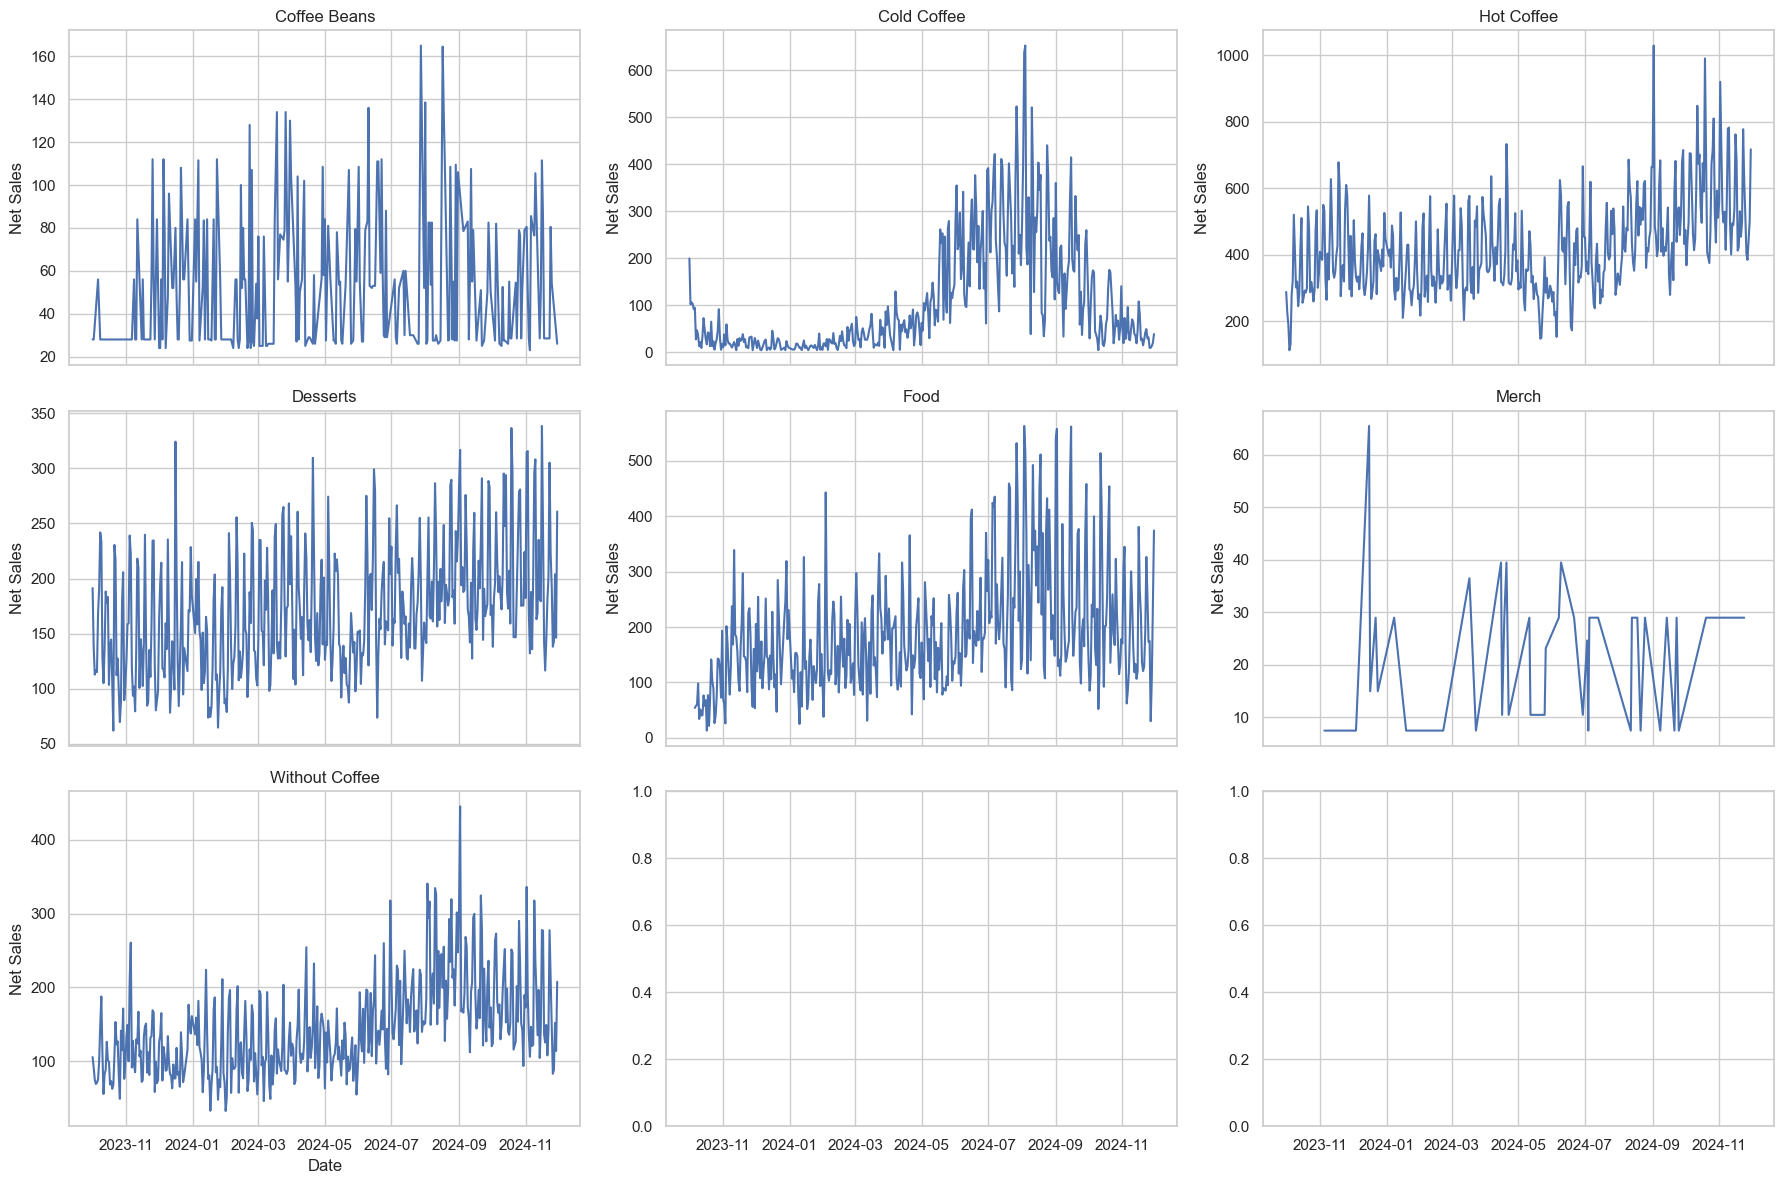

In [58]:
# Set the seaborn style
sns.set(style="whitegrid")

# Create a figure and axes
fig, axes = plt.subplots(3, 3, figsize=(18, 12), sharex=True)

# Plot each category
for ax, column in zip(axes.flatten(), category_sales.drop(columns='closed').columns):
    sns.lineplot(data=category_sales, x=category_sales.index, y=column, ax=ax)
    ax.set_title(column)
    ax.set_xlabel('Date')
    ax.set_ylabel('Net Sales')

# Adjust layout
plt.tight_layout()
plt.show()

In [59]:
category_sales.drop(columns='closed').describe()

Category Name  Coffee Beans  Cold Coffee   Hot Coffee    Desserts        Food  \
count             258.00000   411.000000   421.000000  421.000000  416.000000   
mean               54.20155   105.333066   419.196580  171.703872  188.917837   
std                31.47038   117.927022   138.689117   55.685829  106.834102   
min                23.00000     4.200000   113.350000   62.100000   13.000000   
25%                28.00000    20.800000   315.020000  132.150000  116.000000   
50%                52.00000    51.000000   401.070000  164.200000  165.750000   
75%                79.00000   161.050000   497.570000  204.700000  233.125000   
max               165.00000   652.580000  1028.990000  338.390000  563.000000   

Category Name      Merch  Without Coffee  
count          49.000000      421.000000  
mean           19.598980      145.035938  
std            13.076085       63.585073  
min             7.500000       32.900000  
25%             7.500000       97.150000  
50%            15.000000      134.870000  
75%            29.000000      177.050000  
max            65.500000      444.880000

**Insights from Category Sales Descriptive Statistics**

1. General Observations
- The dataset captures daily sales across seven categories: Coffee Beans, Cold Coffee, Hot Coffee, Desserts, Food, Merch, and Without Coffee.
- The number of data points (**Count**) varies by category, with lower counts for `Coffee Beans` (258 days) and `Merch` (49 days), indicating possible gaps in availability or data collection.

---

2. Sales Performance
- **Highest Average Sales**: 
  - `Hot Coffee` has the highest mean daily sales (419.20), making it the best-performing category on average.
  - `Cold Coffee`, `Without Coffee`, `Desserts`, `Food` follow with means of 105.33, 145.04, 171.7 and 189.9 respectively.
- **Lowest Average Sales**:
  - `Merch` shows the lowest mean daily sales (19.60), which may reflect its non-consumable nature or limited inventory.

---

3. Variability in Sales
- **High Variability**:
  - `Food`, `Cold Coffee` and `Hot Coffee` have high standard deviations (188.9, 117.93 and 138.69), suggesting fluctuating demand.
- **Low Variability**:
  - `Merch` has the lowest standard deviation (13.08), indicating consistent but low sales.
- **Steady Products**:
  - `Desserts` and `Without Coffee` have decent mean daily sales (171.7 and 145.04) but also reasonable standard deviations (55.7 and 63.6), making them products that the business can count on.

---

4. Sales Ranges
- **Minimum Sales**:
  - Some categories have very low minimum daily sales, such as `Food` (13), `Merch` (7.5) and `Cold Coffee`, suggesting underperforming days. The `Cold Coffee` category, however, could be explained due to seasonality.
- **Maximum Sales**:
  - Categories like `Hot Coffee` (1028.99), `Cold Coffee` (652.58), `Food` (563.00) show significant peaks, likely during high-demand periods (e.g., seasons or events).

---

5. Median and Percentiles
- **Median Sales**:
  - `Hot Coffee` has a median of 401.07, reinforcing its consistent popularity.
  - `Merch` has a median of 15, reflecting its lower demand compared to other categories.
- **Spread**:
   - `Cold Coffee` has a high IQR (difference between percentiles) indicating once more the seasonal effect on the category.

---

6. Recommendations
- **Focus on High-Performing Categories**:
  - `Hot Coffee` and `Cold Coffee` drive substantial sales but may require strategies to stabilize fluctuations.
- **Investigate Seasonal Trends**:
  - Peaks in `Cold Coffee` sales suggest strong seasonality. Explore promotions during summer months.
- **Evaluate Underperforming Categories**:
  - Categories like `Merch` could be reassessed for profitability or better marketing.
- **Analyze Missing Data**:
  - Lower counts for `Coffee Beans` and `Merch` show inconsistency in sales, since we are aware that they've been available throughout the whole time period.
- **Missed Opportunities**:
  - Categories like `Desserts`, `Without Coffee` seem to be consistent factors in sales, however increasing focus on them could upgrade them to main revenue sources.
  - The `Food` category is one of the three peak best performing categories, however knowing the efforts and investments of the business for the kitchen and taking into consideration the indications of fluctual demand and underperforming days, it's important that the business develops new strategies in order to obtain maximum value from it.

In [60]:
mean_sales = category_sales.drop(columns='closed').mean().sort_values(ascending=False)
std_sales = category_sales.drop(columns='closed').std().sort_values(ascending=False)

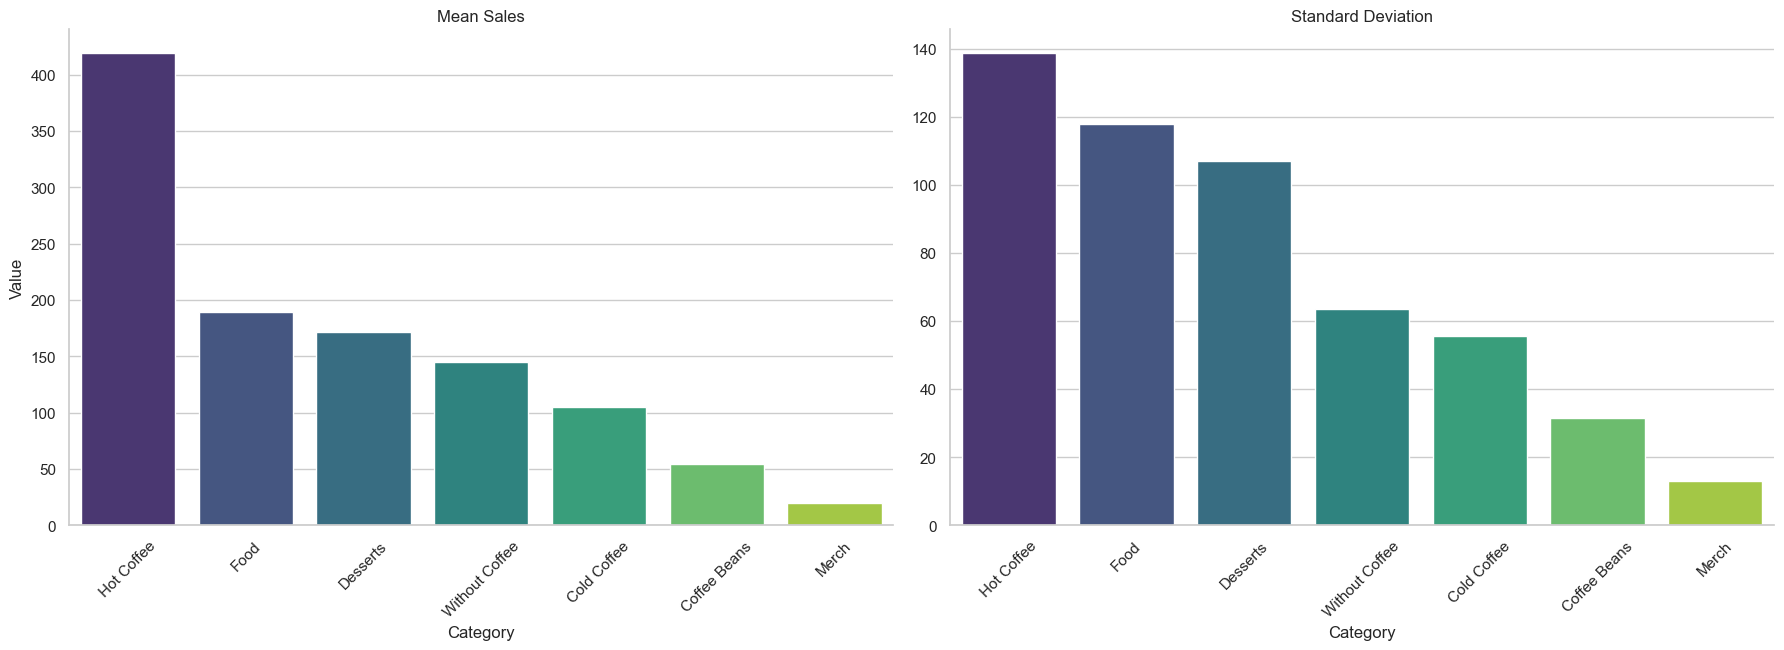

In [61]:
# Combine mean and standard deviation into a single DataFrame for easier plotting
sales_stats = pd.DataFrame({
    'Category': mean_sales.index,
    'Mean Sales': mean_sales.values,
    'Standard Deviation': std_sales.values
})

# Melt the DataFrame to long format for FacetGrid
sales_stats_melted = sales_stats.melt(id_vars='Category', var_name='Metric', value_name='Value')

# Create a FacetGrid
g = sns.FacetGrid(sales_stats_melted, col='Metric', sharey=False, height=6, aspect=1.5)
g.map_dataframe(sns.barplot, x='Category', y='Value', palette='viridis', hue='Category', dodge=False)

# Adjust the titles and labels
g.set_titles(col_template='{col_name}')
g.set_axis_labels('Category', 'Value')
for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(45)

plt.show()


**NaN values**
- There are 6 rows which have NaN values when the store was closed. Except that the only other NaN values are observed in the categories `Merch`, `Food`, `Cold Coffee` due to no sales being made. The categories were available at all times.

In [62]:
category_sales.fillna(0, inplace=True)

In [63]:
category_sales.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 427 entries, 2023-10-01 to 2024-11-30
Freq: D
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Coffee Beans    427 non-null    float64
 1   Cold Coffee     427 non-null    float64
 2   Hot Coffee      427 non-null    float64
 3   Desserts        427 non-null    float64
 4   Food            427 non-null    float64
 5   Merch           427 non-null    float64
 6   Without Coffee  427 non-null    float64
 7   closed          427 non-null    int64  
dtypes: float64(7), int64(1)
memory usage: 30.0 KB


##### Description of the dataframe:

In [128]:
category_data = pd.concat([category_sales, holiday_features, pedestrinization, time_features, macroeconomic, weather_clean], axis=1)

In [3]:
category_data.to_csv('data/category_data.csv')

NameError: name 'category_data' is not defined

- `Category`: Cateogy of products.
- `Net Sales`: Total net sales per day.
- `GDP, CPI, Unemployment Rate, Bond Yields`: Self-described macroeconomic indicators, forward filled to achieve daily frequency.
- `tavg`: Average temperature per day.
- `tmin`: Minimum temperature per day.
- `tmax`: Maximum temperature per day.
- `prcp`: Average precipitation total in mm per day.
- `snow`: Snow depth in mm per day.
- `wdir`: Average wind direction in degrees.
- `wspd`: Average wind speed per day.
- `pres`: Average sea level air pressure in hPa.
- `holiday_type`: Values (0, 1, 2) where 0 indicates not a holiday, 1 indicates a regular holiday, and 2 indicates a major holiday.
- `is_pedestrian`: Boolean flag (1 or 0) indicating whether the street where the cafe is located was pedestrianized on that day.
- `day_of_week`: Day of the week (0 = Monday, 6 = Sunday).
- `day_of_month`: Day of the month.
- `month`: Month of the year.
- `year`: Year.
- `quarter`: Quarter of the year (1 to 4).
- `is_weekend`: Boolean flag (1 or 0) indicating whether the day is a weekend.

In [64]:
category_data = pd.read_csv('data/category_data.csv', index_col = 0)
category_data.head()

Coffee Beans  Cold Coffee  Hot Coffee  Desserts  Food  Merch  \
2023-10-01          28.0       199.35      288.40    191.37   0.0    0.0   
2023-10-02          28.0       101.75      226.42    137.40   0.0    0.0   
2023-10-03           0.0       105.84      189.10    112.85   0.0    0.0   
2023-10-04           0.0       103.05      113.35    116.95   0.0    0.0   
2023-10-05           0.0        91.55      131.45    115.12   0.0    0.0   

            Without Coffee  closed  holiday_type  is_pedestrian  ...  \
2023-10-01          105.86       0             0              0  ...   
2023-10-02           91.65       0             0              0  ...   
2023-10-03           75.16       0             0              0  ...   
2023-10-04           69.50       0             1              0  ...   
2023-10-05           71.20       0             0              0  ...   

            Unemployment Rate  Bond Yields  tavg  tmin  tmax  prcp  snow  \
2023-10-01                5.7        4.062  20.0  15.2  24.9   0.2   0.0   
2023-10-02                5.7        4.062  18.6  13.2  24.1   1.1   0.0   
2023-10-03                5.7        4.062  22.7  17.8  27.6   0.0   0.0   
2023-10-04                5.7        4.062  24.5  18.7  30.3   0.0   0.0   
2023-10-05                5.7        4.062  23.9  19.9  27.8   0.0   0.0   

             wdir  wspd    pres  
2023-10-01  342.0   4.2  1023.5  
2023-10-02  326.0   2.7  1022.9  
2023-10-03  196.0   4.1  1018.5  
2023-10-04  178.0   3.6  1020.3  
2023-10-05  174.0   5.5  1018.2  

[5 rows x 28 columns]

In [65]:
category_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 427 entries, 2023-10-01 to 2024-11-30
Data columns (total 28 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Coffee Beans       427 non-null    float64
 1   Cold Coffee        427 non-null    float64
 2   Hot Coffee         427 non-null    float64
 3   Desserts           427 non-null    float64
 4   Food               427 non-null    float64
 5   Merch              427 non-null    float64
 6   Without Coffee     427 non-null    float64
 7   closed             427 non-null    int64  
 8   holiday_type       427 non-null    int64  
 9   is_pedestrian      427 non-null    int64  
 10  day_of_week        427 non-null    int64  
 11  day_of_month       427 non-null    int64  
 12  month              427 non-null    int64  
 13  year               427 non-null    int64  
 14  quarter            427 non-null    int64  
 15  is_weekend         427 non-null    int64  
 16  GDP            

##### Correlation

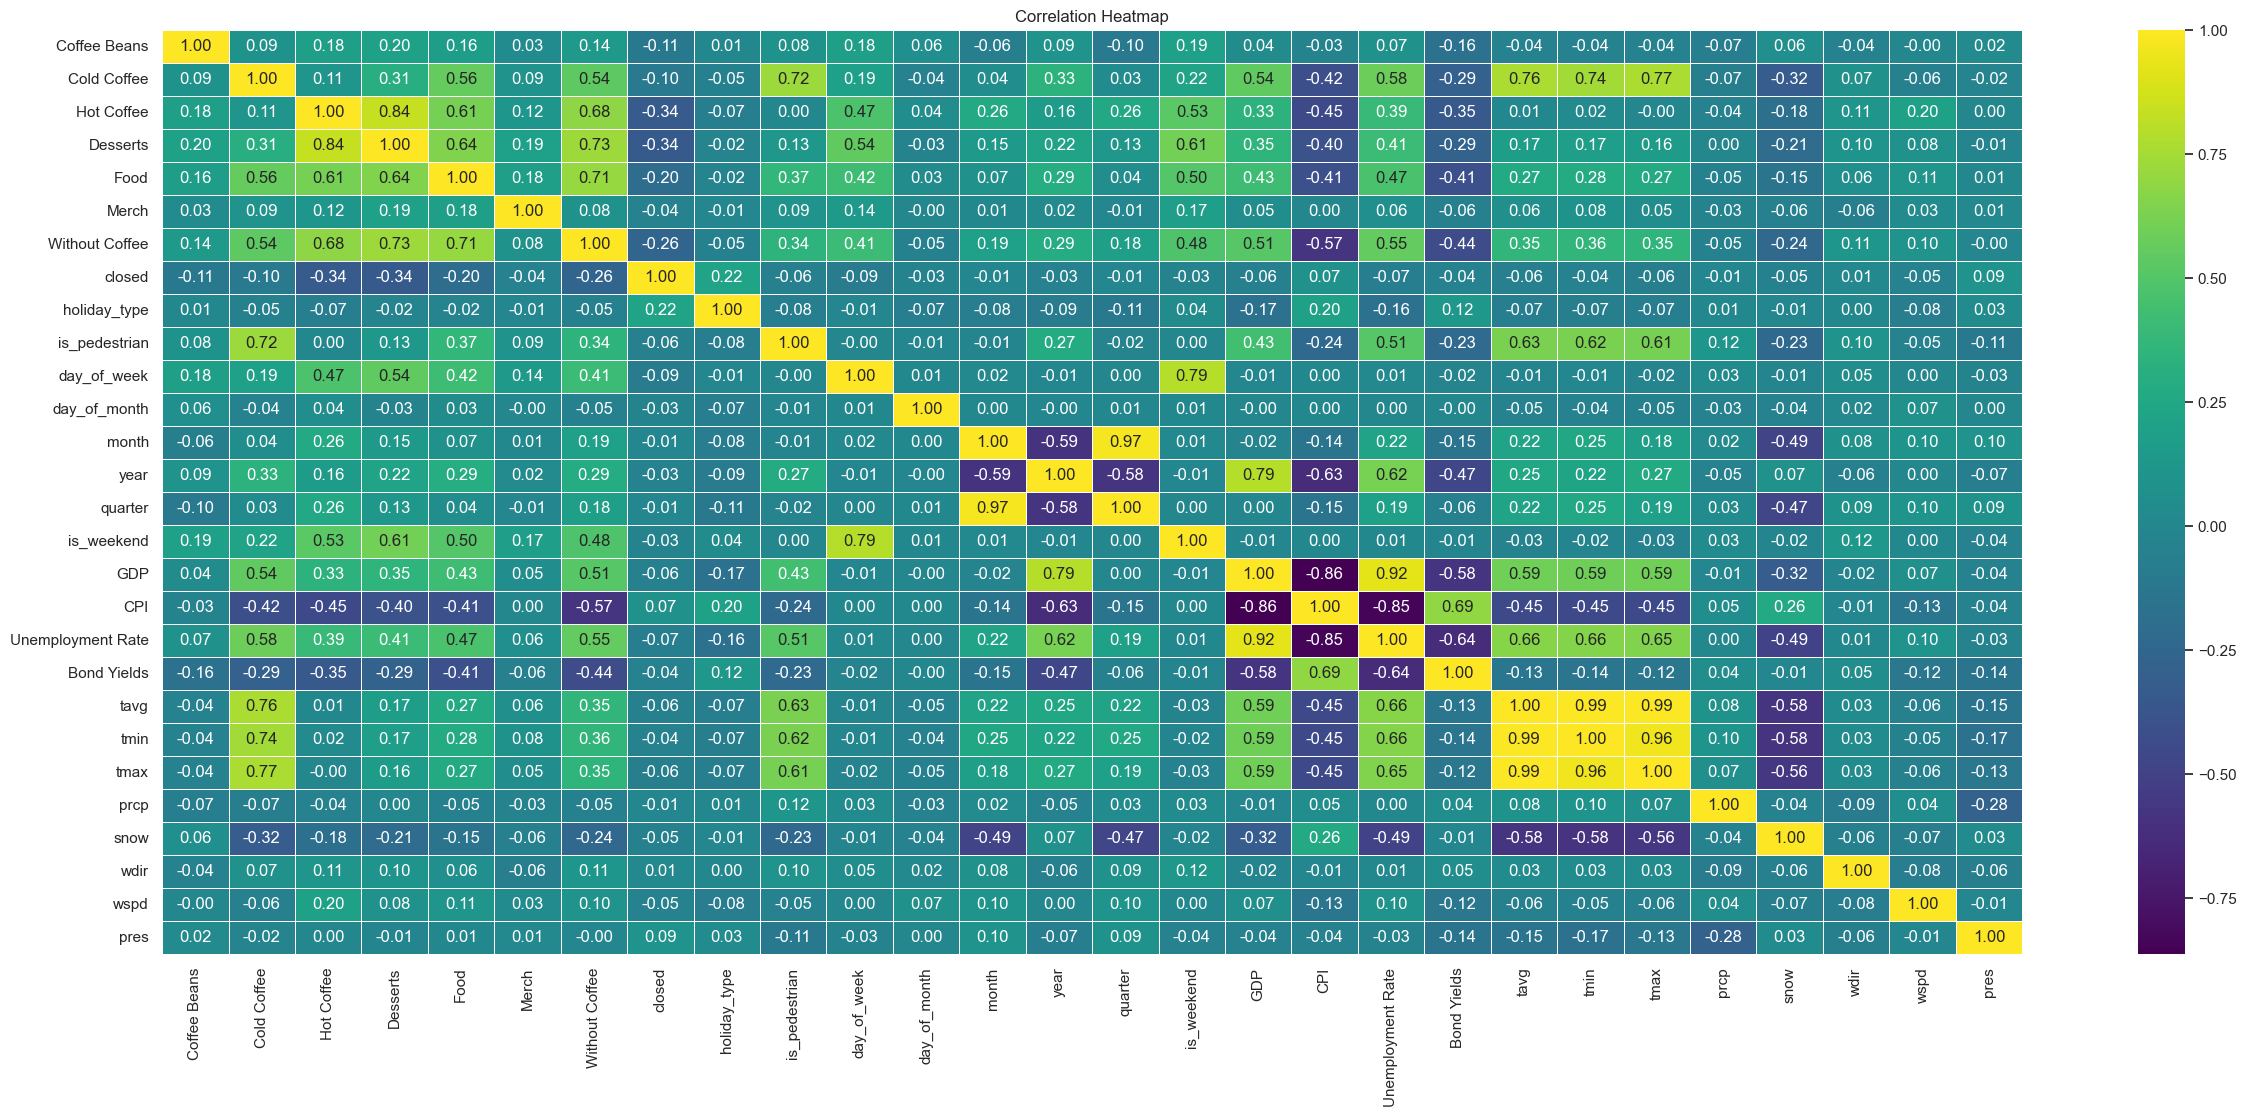

In [66]:
vs.plot_correlation_heatmap(category_data)

**Insights from correlation heatmap**
- **Weather**:
    - The temperature features seem to affect sales, especially the `Cold Coffee` sales, proving seasonality once again. We can also confirm this through the `is_pedestrian` feature which is True during the summer season and seems to also have an impact on sales.
    - The `snow` indicator also seems to have a negative impact on sales.
---
- **Between product categories**:
    - We observe correlation between product categories, the `Without Coffee` category seems to be correlated with `Food` and `Desserts` sales. Also, the `Hot Coffee` is **highly** correlated with `Desserts`.
---
- **Macroeconomic features**:
    - The macroeconomic indicators seem to also have a significant impact on sales. As expected the `GDP` has a positive relation to sales, while the `CPI` and `Bond Yields` have a negative impact.
    - A surprising find is that the `Unemployment Rate` has positive correlation to sales, meaning that while unemployment rises the sales are rising with it. However, we can also see that `Unemployment Rate` is also highly positively correlated with temperature and negatively correlated with `snow` showing us we observe higher unemployment rates during the summer season. Hence, we suspect that this is the explanation.
---
- **Time based features**:
    - As expected, the `is_weekend` and `day_of_week` features affect sales. We need to analyze further to see whether these two features provide the same information or there's further segmentation on sales impact between the weekdays.
---
- **Merch & Coffee Beans**:
    - The `Merch` and `Coffee Beans` categories seem to be minimally influenced from features. That poses a problem since it makes developing a strategy on how to improve sales in these particular categories difficult.
---
- **Cold Coffee**:
    - The `Cold Coffee` is highly correlated with multiple features, indicating some of the causes of its high volatility.
---
- **Holiday type**:
    - The `holiday_type` seems to have no impact whatsoever on sales. Needs further investigation.
---
- **Unecessary features**:
    - There are certain features that show correlation close to 0 with all features. These features don't provide value in the analysis and are likely "overshadowed" by other features. These are:
        - `day_of_month`
        - `prcp`
        - `pres`
        - `wdir`
        - `tmin`, `tmax` - redundant features
        - `month` - redundant since `quarter` depicts similar information
---
- **Conclusions**:
    - The correlation between products shows that the business can implement strategies like creating combos of `Without Coffee` items and `Food`, `Desserts` items, or give discounts on sales of `Desserts` after the purchase of `Hot Coffee`. In a more unconventional approach, it can reinvent its menu providing pairs of beverages and desserst. For example, create dessert menu where each item is paired with a coffee that has similar tasting notes.
    - Promotion of `Cold Coffee` during the summer season and especially during the pedestranization of the street should be a priority.
    - The effect of macroeconomic features should be analysed further to examine the magnitude of their impact on sales and whether it correlates with the weather features.

In [67]:
category_data = pd.get_dummies(category_data, columns=['quarter', 'day_of_week', 'holiday_type'])

In [68]:
category_data = category_data.drop(columns = ['day_of_month', 'month', 'prcp', 'pres', 'wdir', 'tmin', 'tmax'])

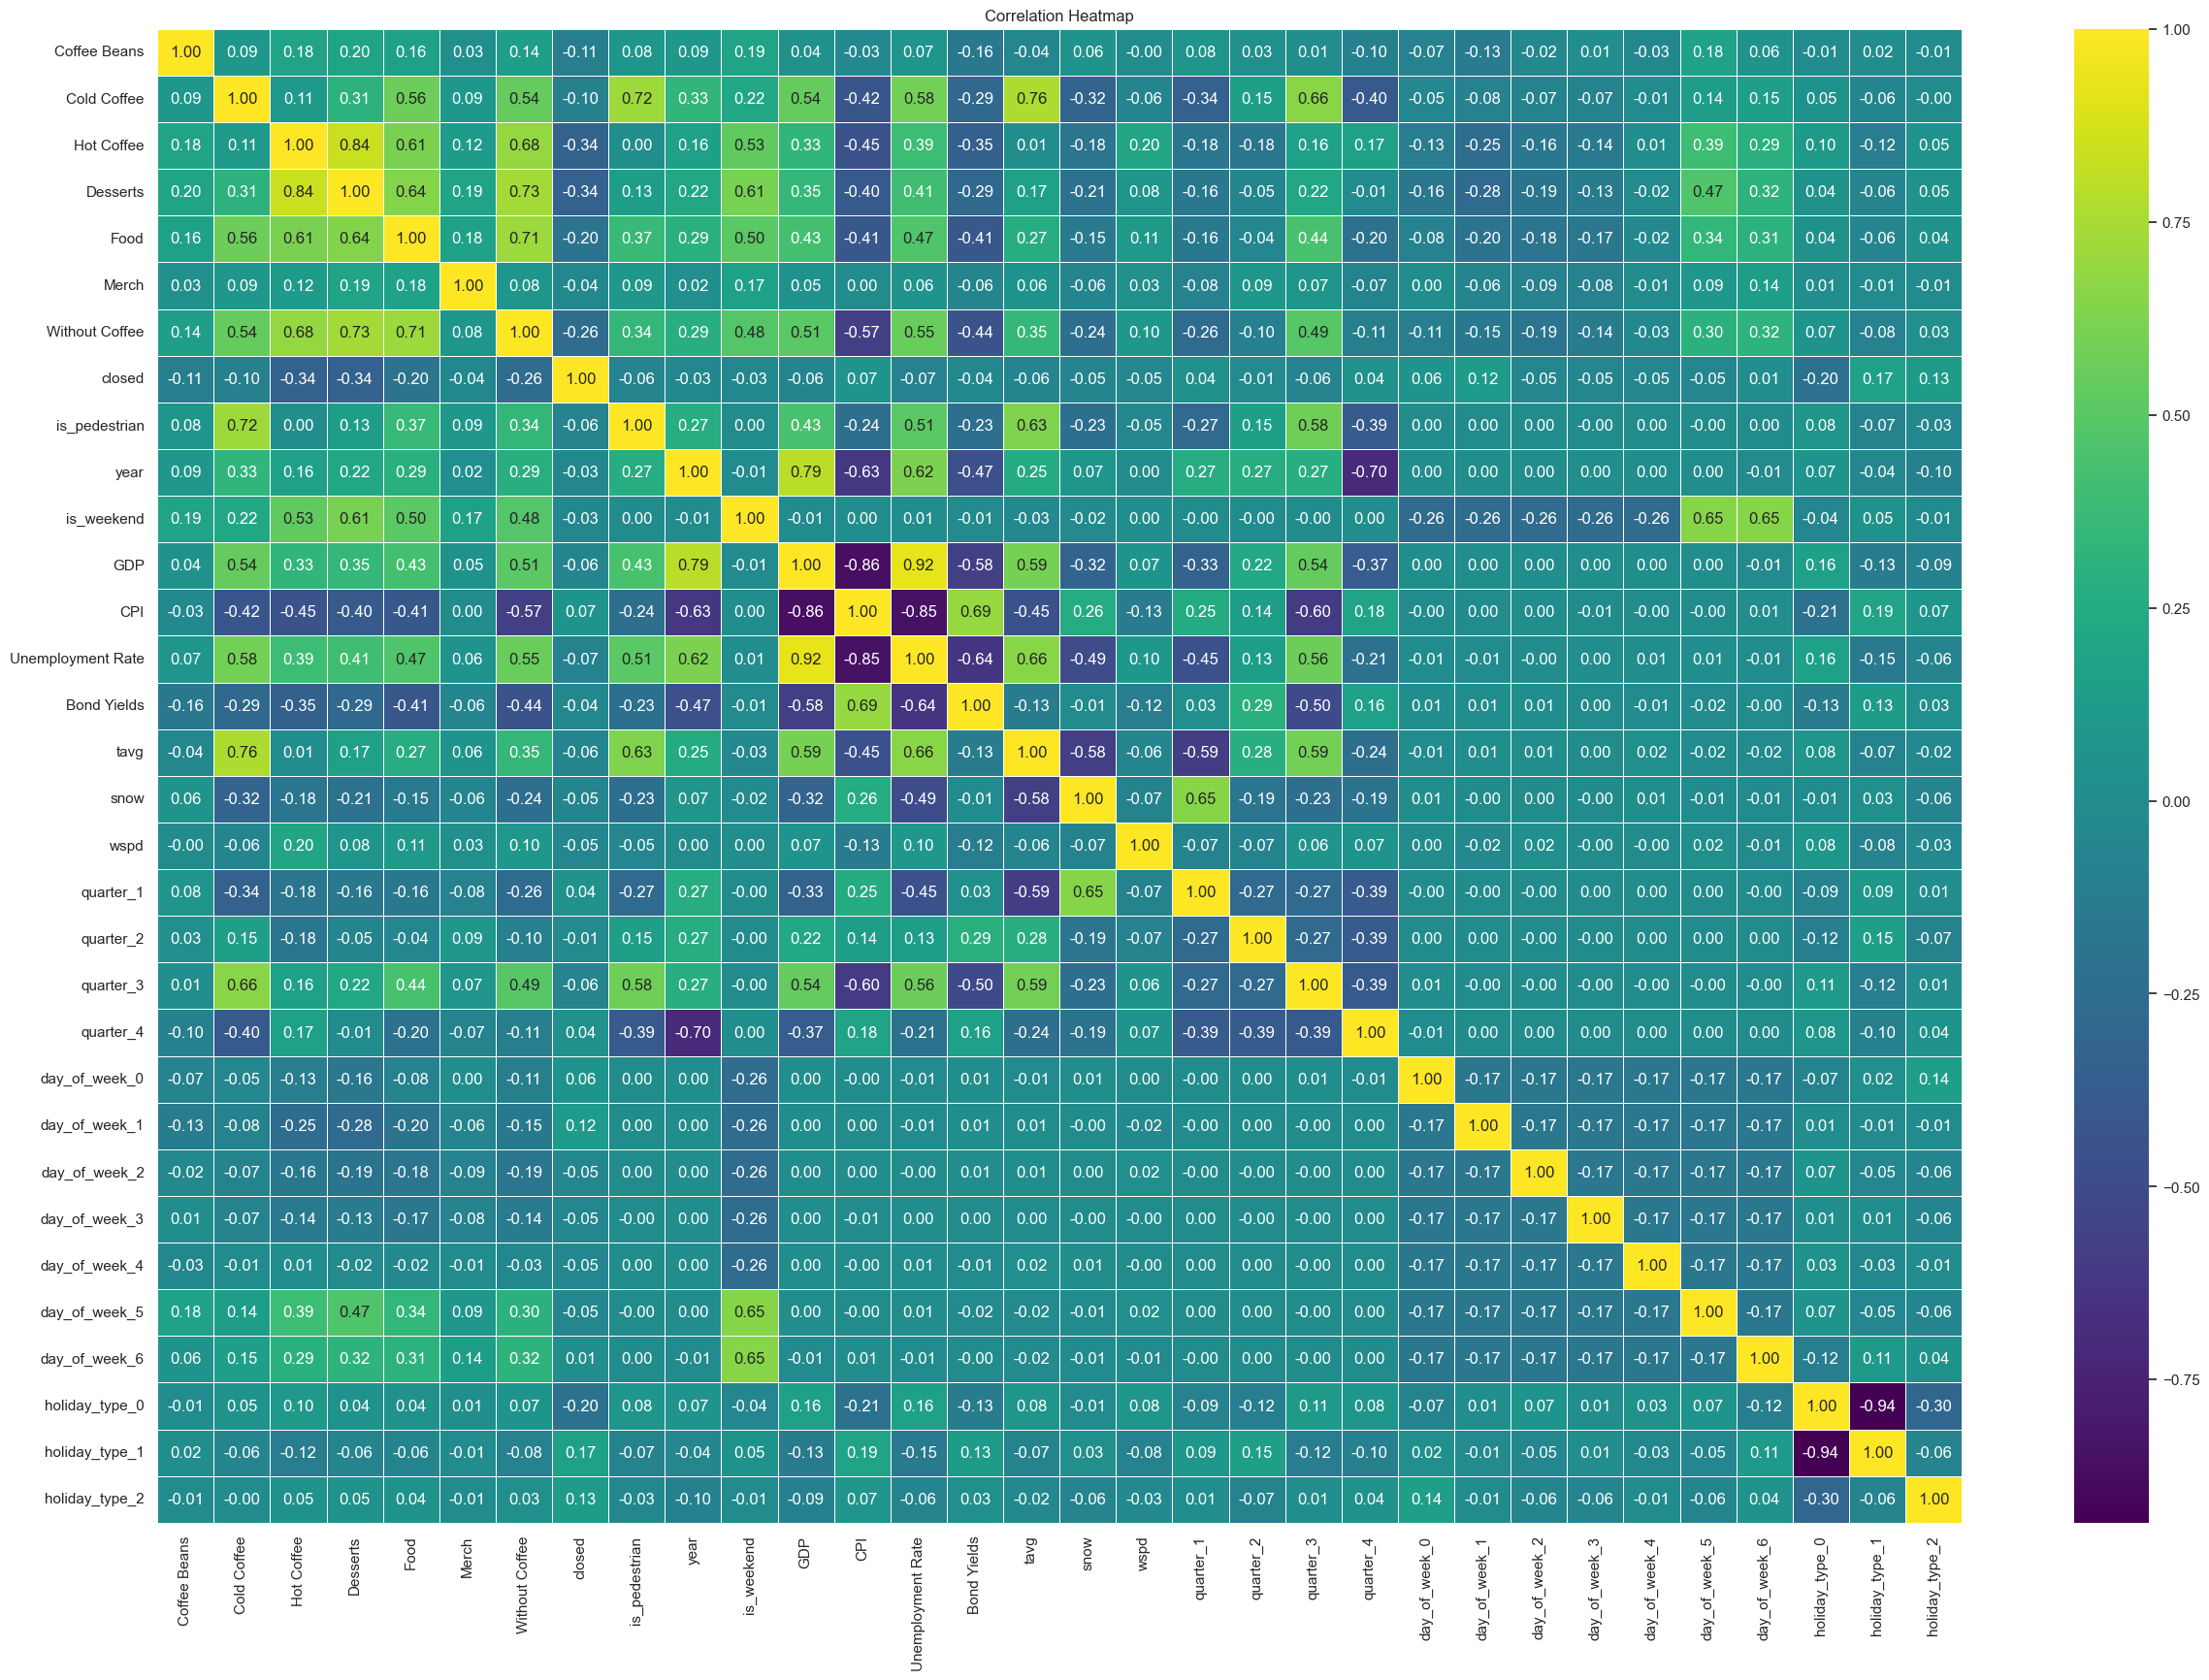

In [69]:
vs.plot_correlation_heatmap(category_data, figsize=(30, 20))

- The `holiday_type` features seem to have no direct impact on sales (max abs correlation (0.12))
- There are some features that are redundant.
    - `day_of_week_5` and `day_of_week_6` are highly correlated with `is_weekend` since they are representing the same information.

In [70]:
category_data = category_data.drop(columns = ['day_of_week_5', 'day_of_week_6'])

##### Feature importance (XGBoost)

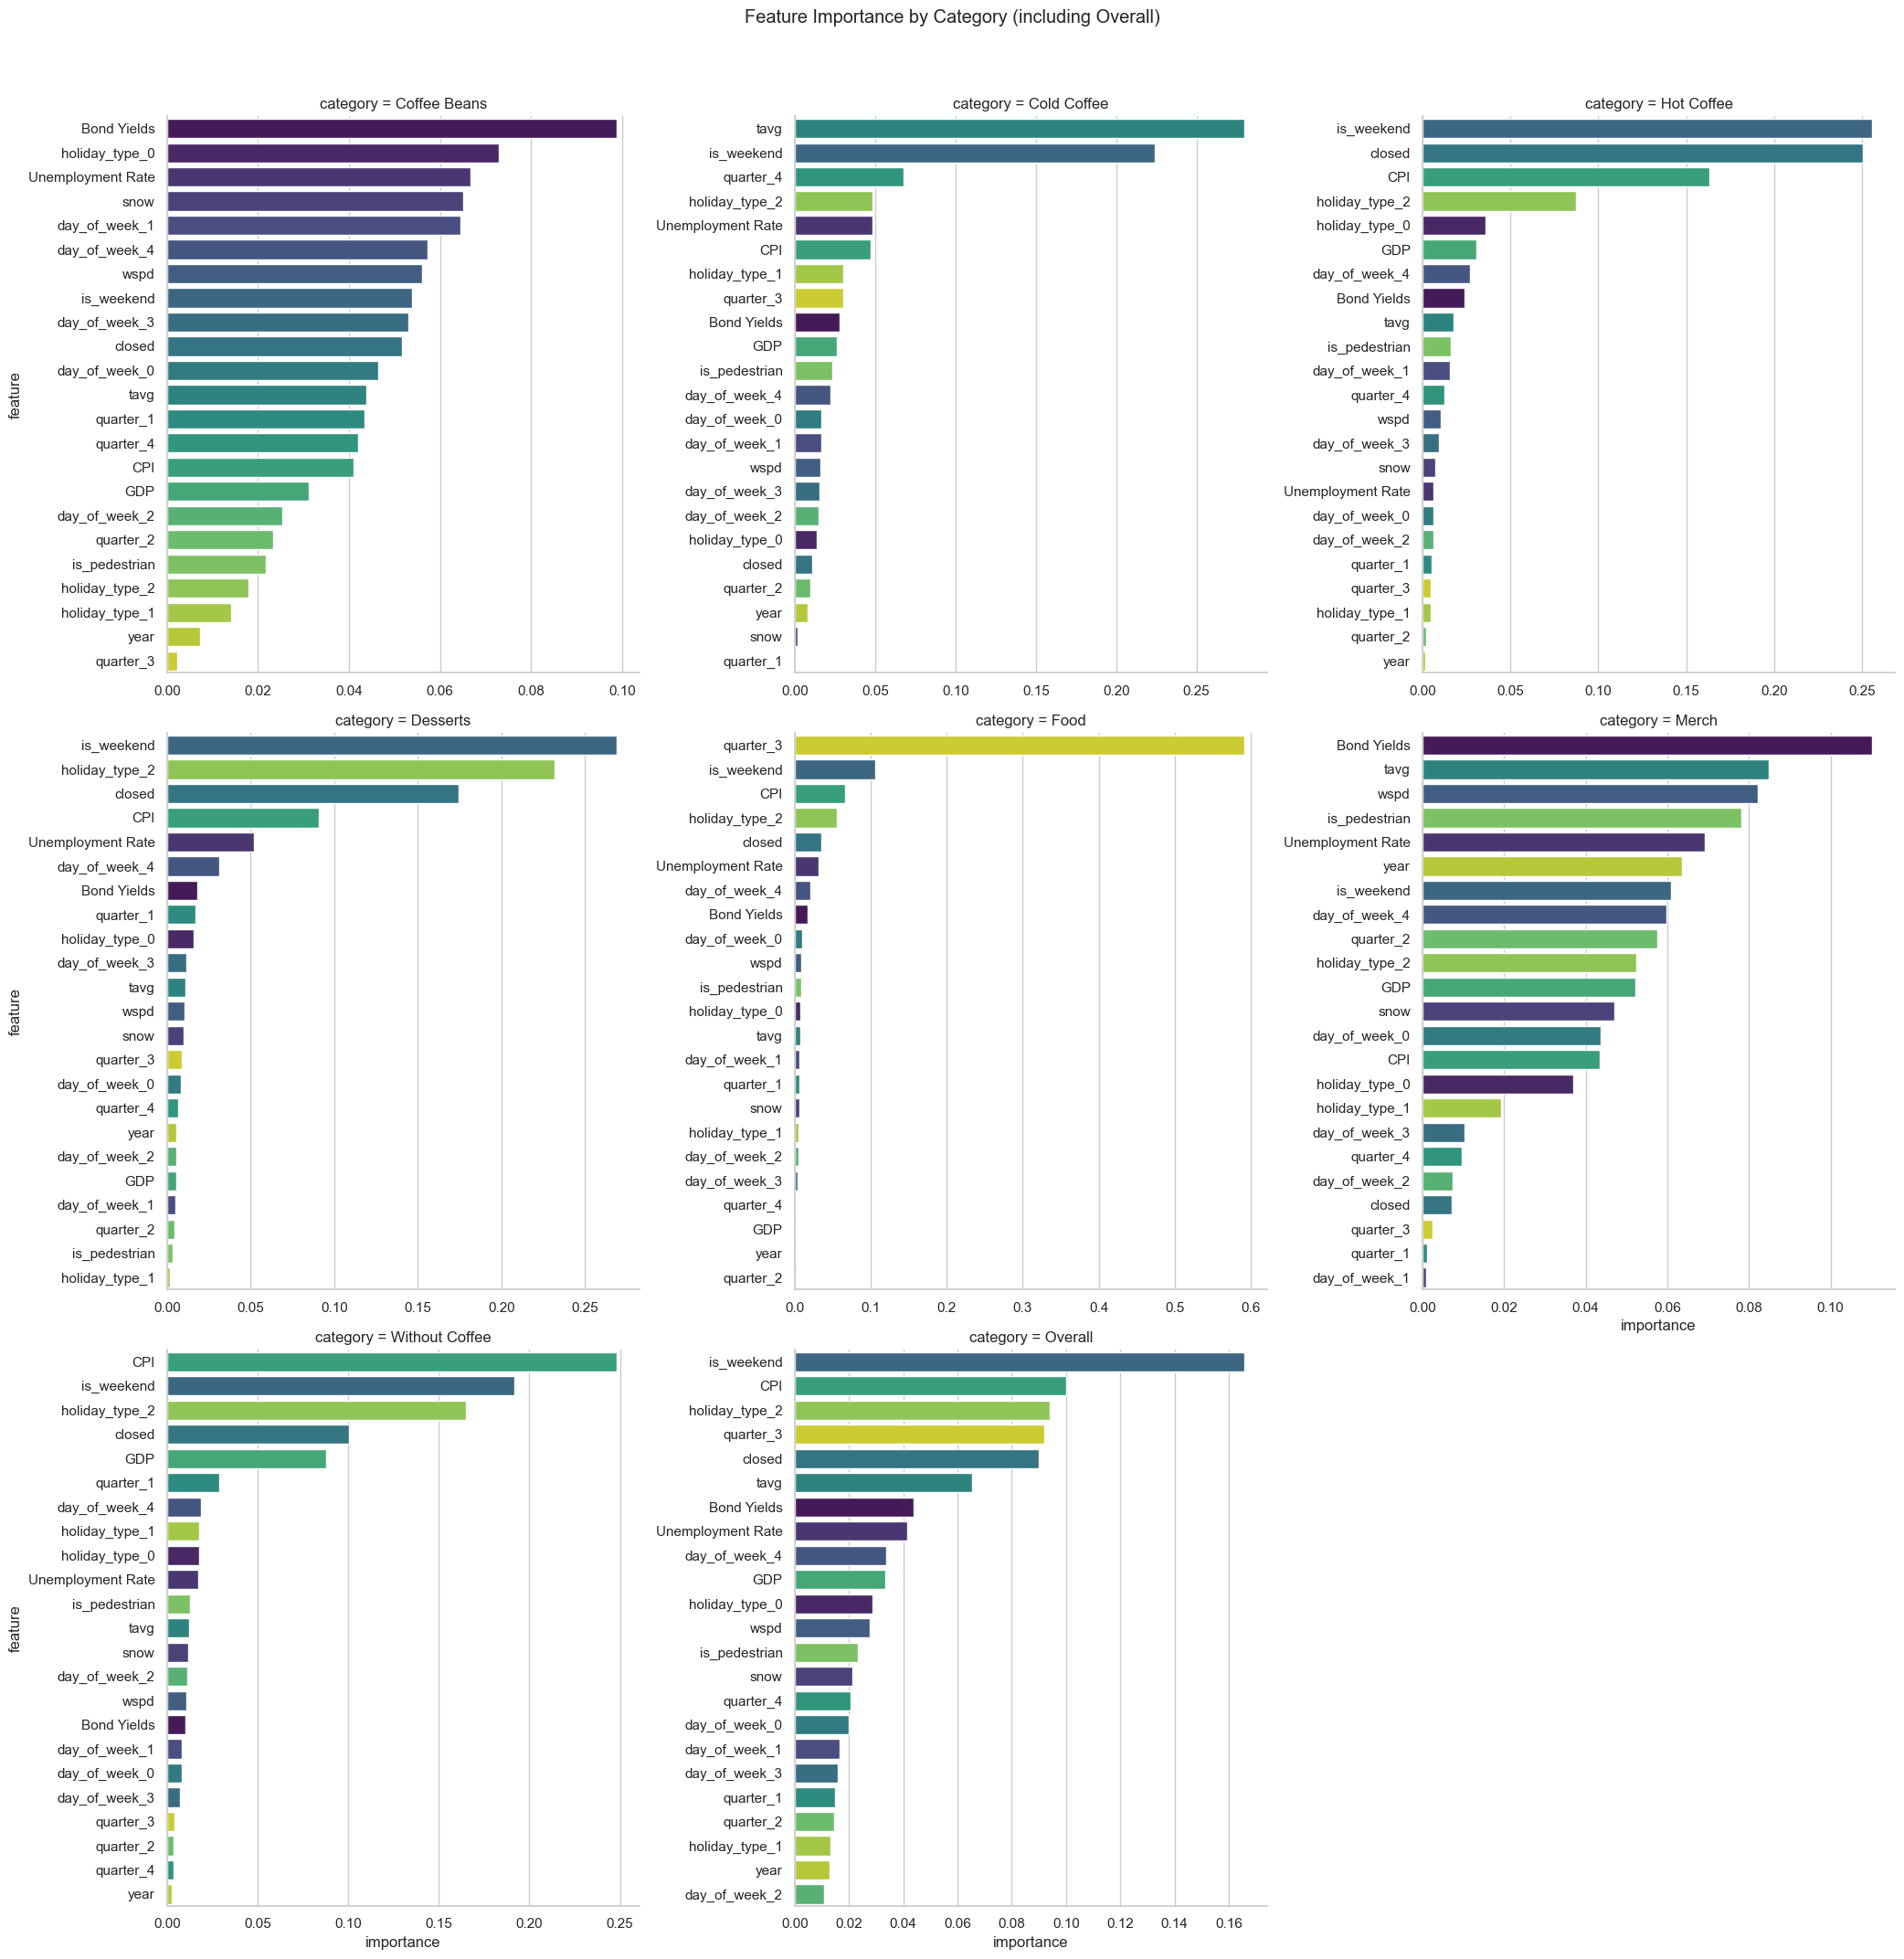

In [71]:
# Feature importnance for the first seven columns (categories)
categories = category_data.columns[:7]
importance_data = mt.analyze_category_feature_importance(category_data, categories)

**Insights from feature importance analysis**
- **Holiday type**
    - The `holiday_type_2` feature seem to provide valuable information to the model afterall, even though it didn't have direct impact on sales as shown from the correlation analysis.
- **Macroeconomic features**
    - They seem to also play an important role, with `CPI` being one of the most important features for almost all categories and ranked 2nd overall.
- **Weekend**
    - The `is_weekend` feature seems to be highly impactful in all categories, which is something that we witnessed in the correlation analysis as well. This shows that the store performs much better during weekends.
- **Time based features**
    - These features seem to play a role in the decision making for XGBoost, however they have smaller impact than expected.

##### Macroconomic feature analysis

We've seen that the features `GDP`, `CPI`, `Unemployment Rate`, `Bond Yields` are significantly correlated with the sales per category, but there seems to be correlation with other features leading to doubts over whether the impact on sales is due to the seasonality of the indicators.

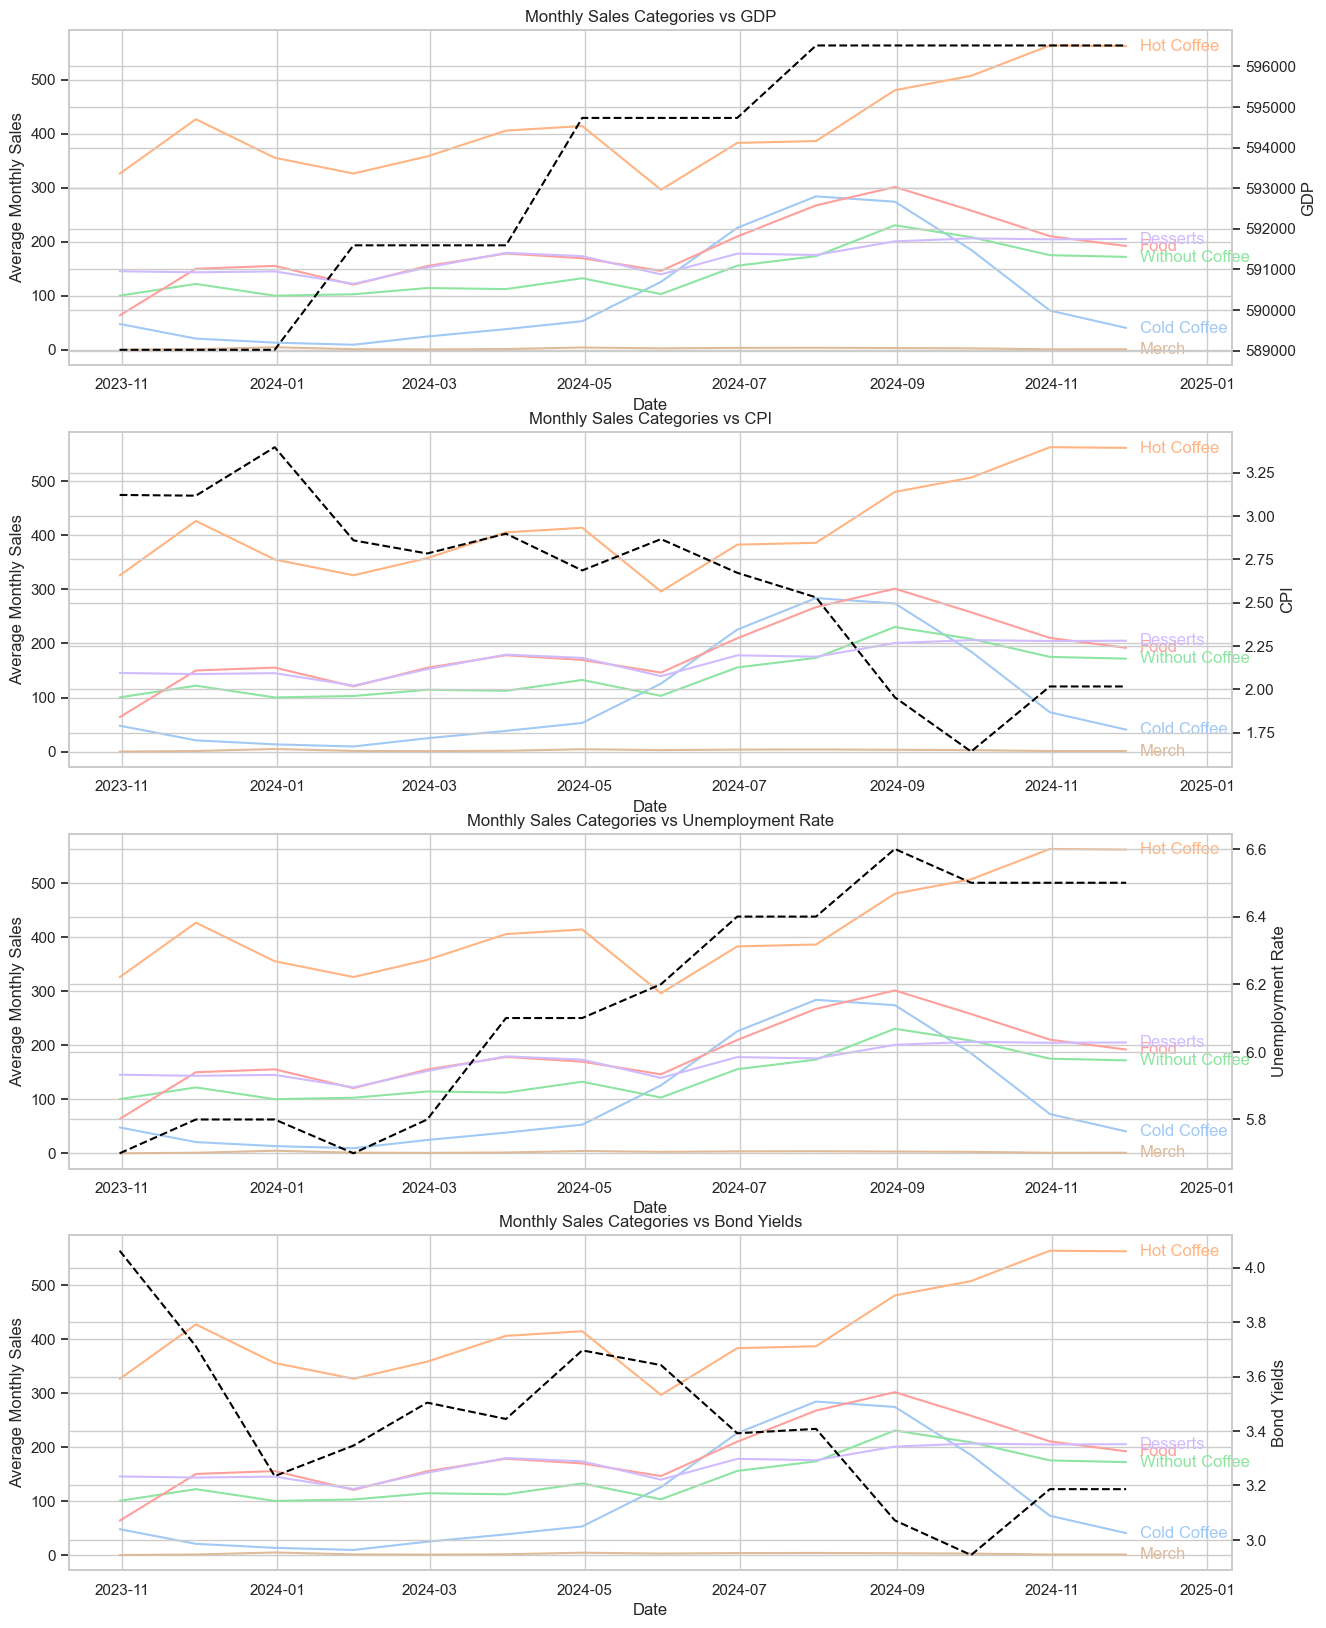

In [72]:
vs.plot_monthly_sales_vs_macro(category_data)

In [73]:
lags = [7, 14, 10, 30, 45]
cols = ['GDP', 'CPI', 'Unemployment Rate', 'Bond Yields']
category_data = fe.create_lag_features(category_data, cols,lags).dropna()

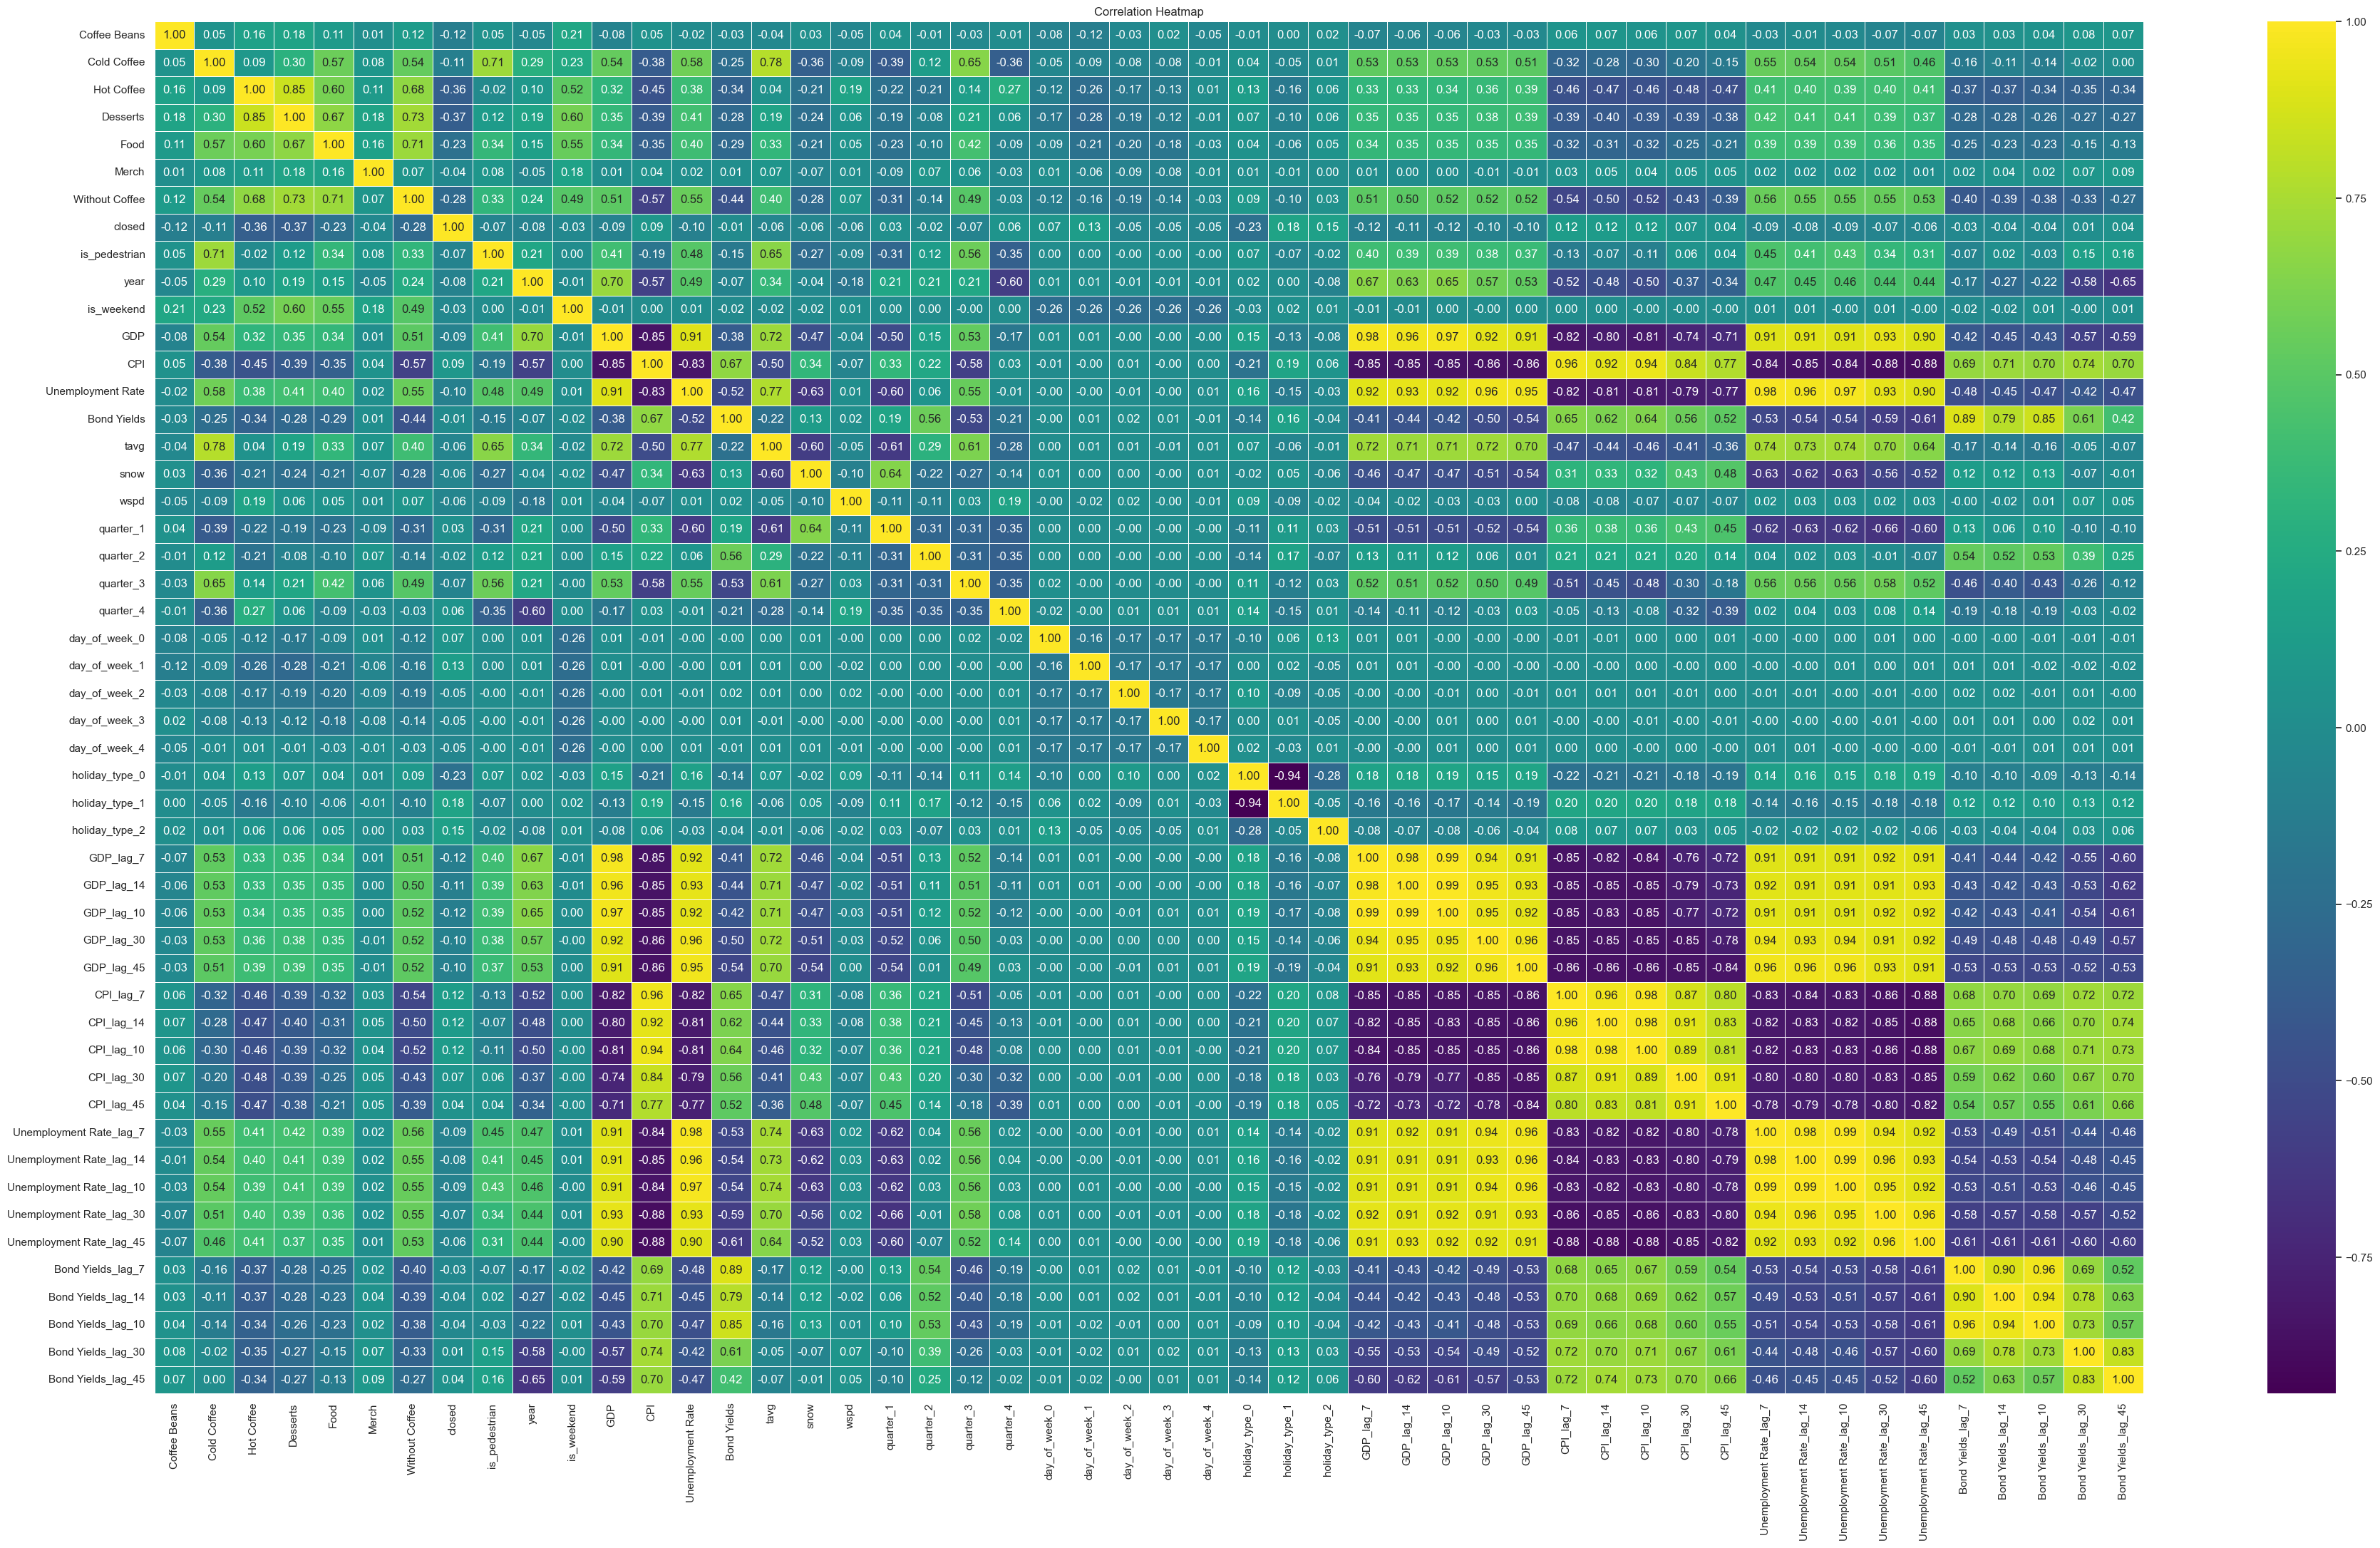

In [74]:
vs.plot_correlation_heatmap(category_data, figsize=(45, 25))

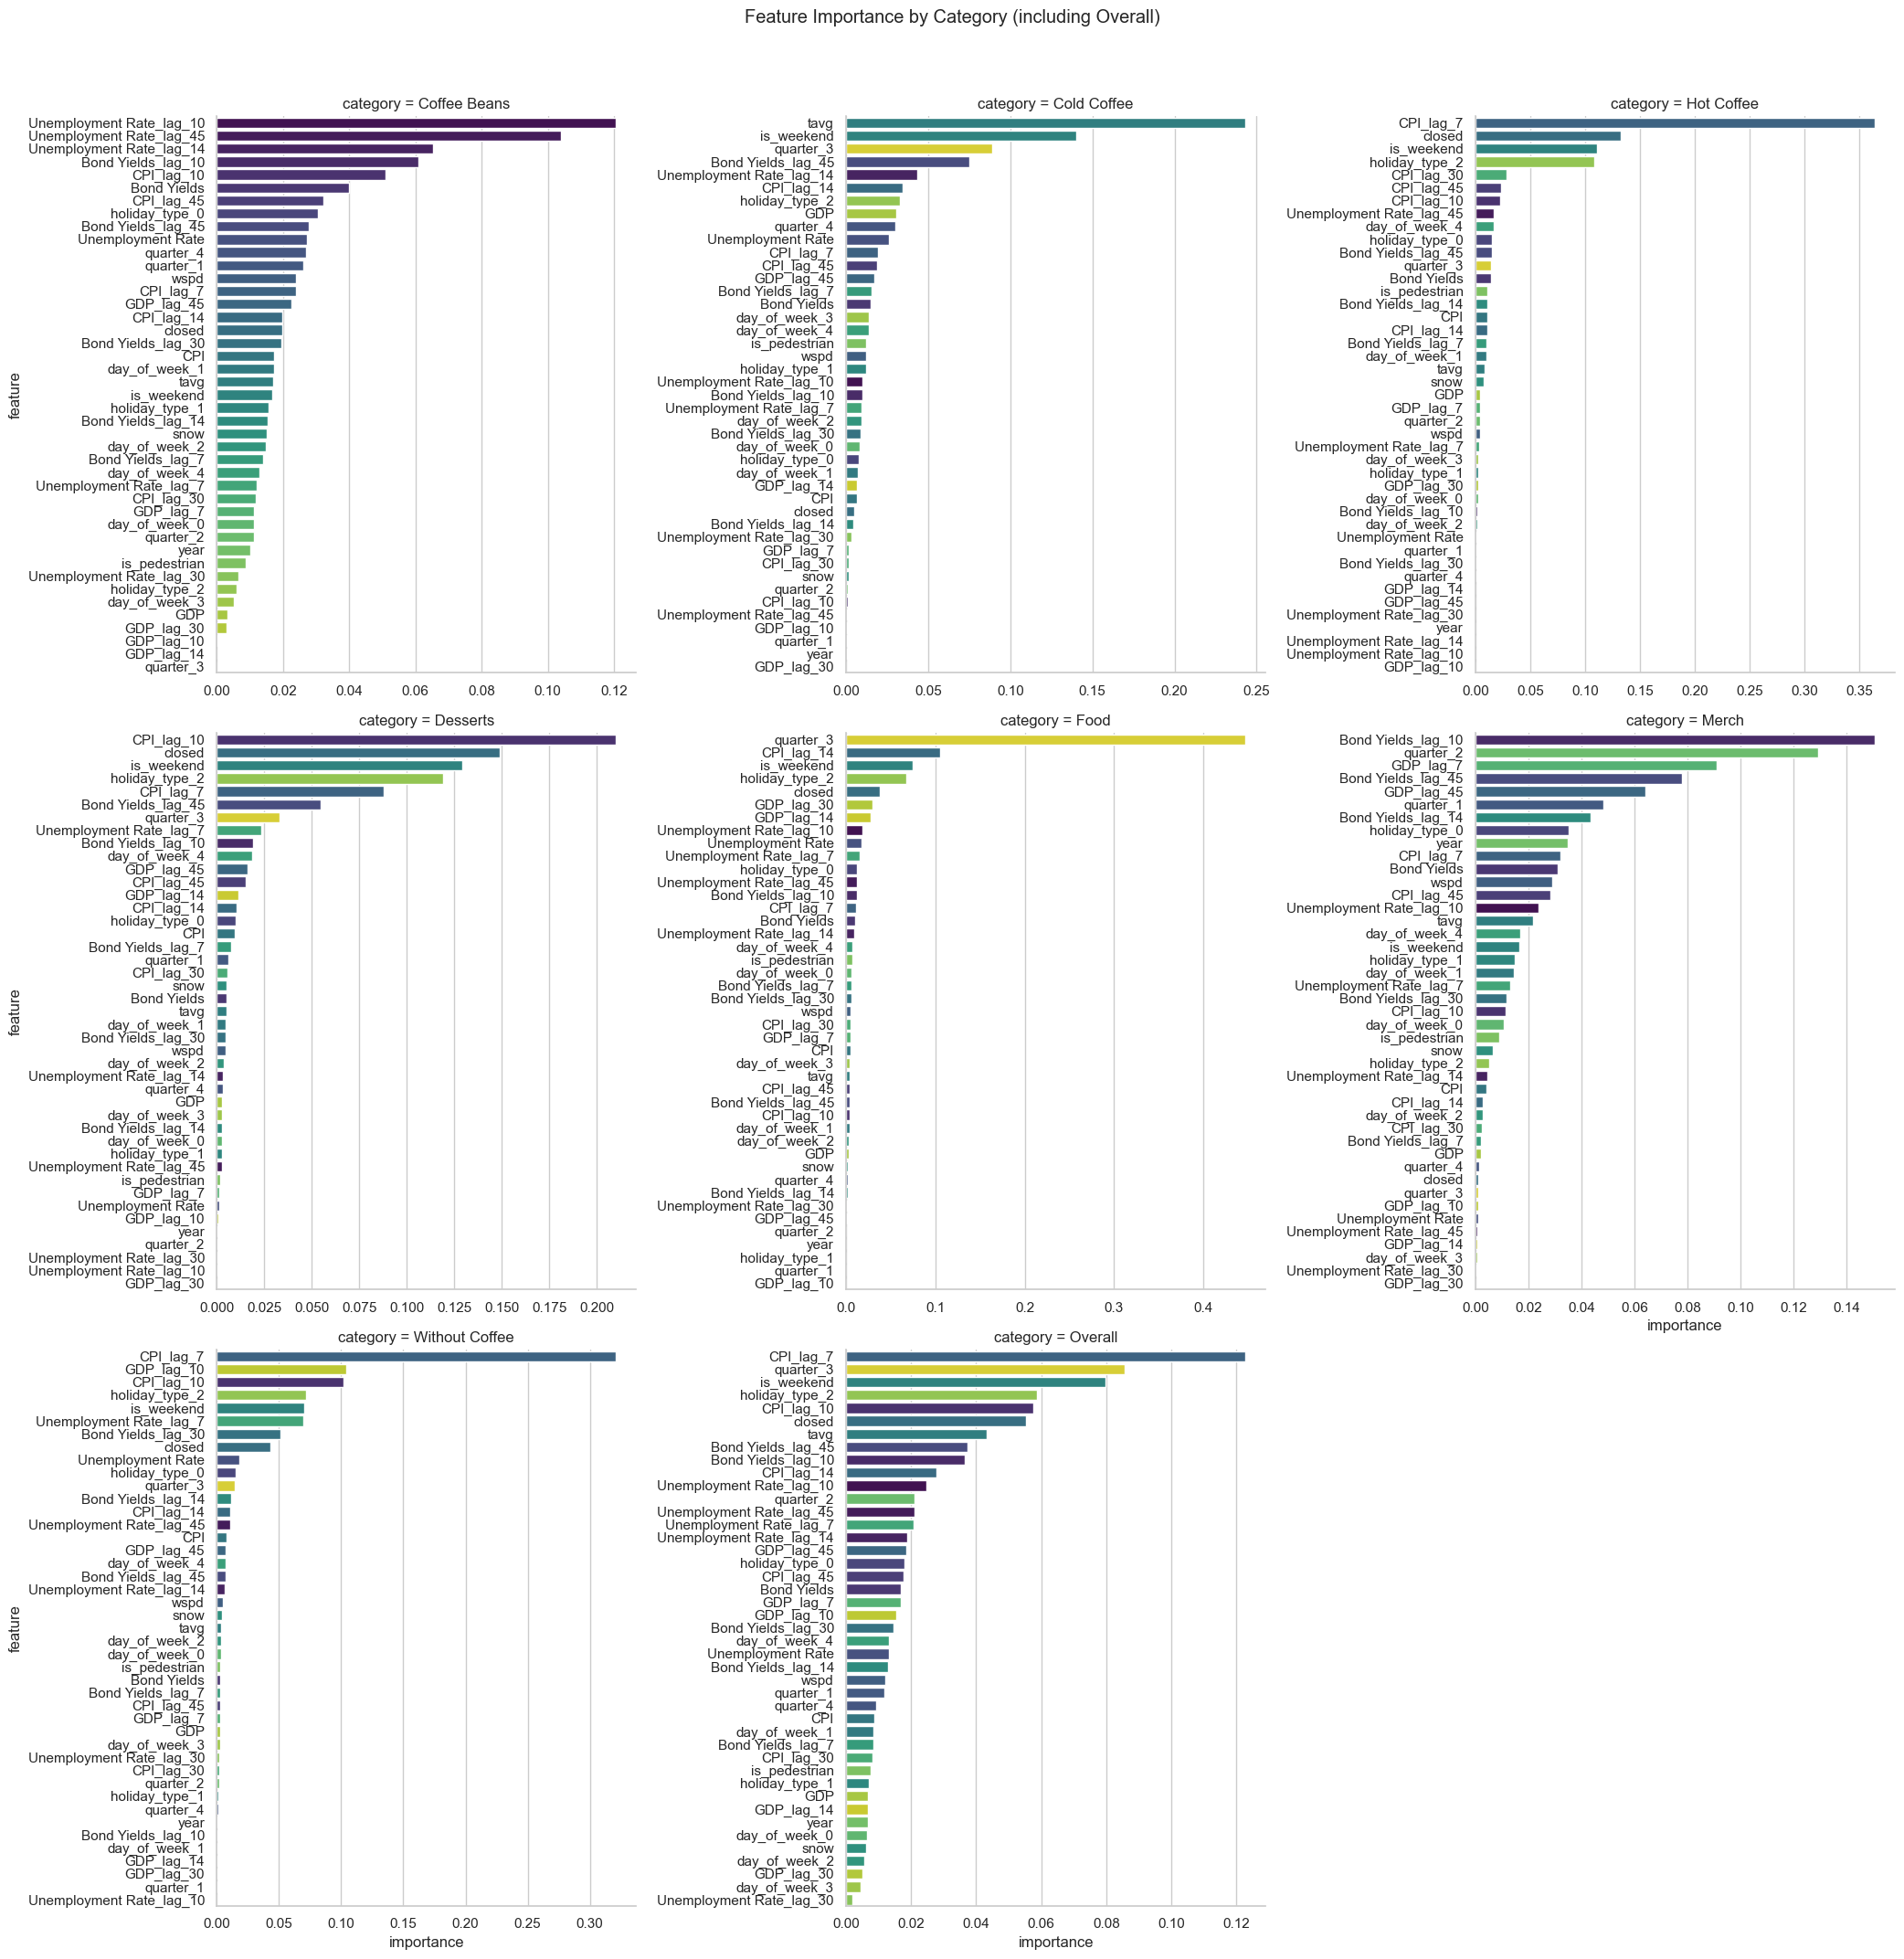

feature  importance category
301                 CPI_lag_7    0.122811  Overall
302                 quarter_3    0.085661  Overall
303                is_weekend    0.079709  Overall
304            holiday_type_2    0.058635  Overall
305                CPI_lag_10    0.057451  Overall
306                    closed    0.055425  Overall
307                      tavg    0.043355  Overall
308        Bond Yields_lag_45    0.037322  Overall
309        Bond Yields_lag_10    0.036415  Overall
310                CPI_lag_14    0.027793  Overall
311  Unemployment Rate_lag_10    0.024747  Overall
312                 quarter_2    0.021179  Overall
313  Unemployment Rate_lag_45    0.021120  Overall
314   Unemployment Rate_lag_7    0.020808  Overall
315  Unemployment Rate_lag_14    0.018821  Overall
316                GDP_lag_45    0.018419  Overall
317            holiday_type_0    0.018086  Overall
318                CPI_lag_45    0.017765  Overall
319               Bond Yields    0.016962  Overall
320                 GDP_lag_7    0.016841  Overall
321                GDP_lag_10    0.015297  Overall
322        Bond Yields_lag_30    0.014605  Overall
323             day_of_week_4    0.013312  Overall
324         Unemployment Rate    0.013192  Overall
325        Bond Yields_lag_14    0.012906  Overall
326                      wspd    0.012011  Overall
327                 quarter_1    0.011817  Overall
328                 quarter_4    0.009298  Overall
329                       CPI    0.008714  Overall
330             day_of_week_1    0.008374  Overall
331         Bond Yields_lag_7    0.008282  Overall
332                CPI_lag_30    0.008195  Overall
333             is_pedestrian    0.007556  Overall
334            holiday_type_1    0.007059  Overall
335                       GDP    0.006832  Overall
336                GDP_lag_14    0.006761  Overall
337                      year    0.006711  Overall
338             day_of_week_0    0.006462  Overall
339                      snow    0.006115  Overall
340             day_of_week_2    0.005466  Overall
341                GDP_lag_30    0.005100  Overall
342             day_of_week_3    0.004586  Overall
343  Unemployment Rate_lag_30    0.002024  Overall

In [75]:
importance = mt.analyze_category_feature_importance(category_data, categories)
overall_importance = importance.loc[importance['category'] == 'Overall'].sort_values(by='importance', ascending=False)
overall_importance

We can see that the lag features are highly relevant overall, especially the lag features of CPI and the lag features of 7 and 14 days in generall. <br>
This indicates that the macroeconomic can be predictors of the category sales. <br>
Since we see strong performance between 7 and 14 days it would be good idea to add a lag feature of 10 days. <br>
However, there are features that seem to have very low feature importance and it might benefit our model if we remove them with the exception of certain features that due to domain_knowledge we know that have an effect on sales.

In [ ]:
# Removing features that have less than 0.01 feature importance
low_features = overall_importance.loc[(overall_importance['importance'] < 0.01) & (~overall_importance['feature'].isin(['snow', 'is_pedestrian']))]
category_data_filtered = category_data.drop(columns=low_features['feature'])
category_data_filtered.columns

Index(['Coffee Beans', 'Cold Coffee', 'Hot Coffee', 'Desserts', 'Food',
       'Merch', 'Without Coffee', 'closed', 'is_pedestrian', 'is_weekend',
       'Unemployment Rate', 'Bond Yields', 'tavg', 'snow', 'wspd', 'quarter_1',
       'quarter_2', 'quarter_3', 'day_of_week_4', 'holiday_type_0',
       'holiday_type_2', 'GDP_lag_7', 'GDP_lag_10', 'GDP_lag_45', 'CPI_lag_7',
       'CPI_lag_14', 'CPI_lag_10', 'CPI_lag_45', 'Unemployment Rate_lag_7',
       'Unemployment Rate_lag_14', 'Unemployment Rate_lag_10',
       'Unemployment Rate_lag_45', 'Bond Yields_lag_14', 'Bond Yields_lag_10',
       'Bond Yields_lag_30', 'Bond Yields_lag_45'],
      dtype='object')